In [1]:
import sys
import os
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import json
import time 
import pickle as pkl
import matplotlib.pyplot as plt

currDir = os.path.abspath('')

# root directory for all necessary modules to be loaded
parentDir = os.path.dirname( currDir )

# directory for modules containing model related definitions
modelDefinitionDir = os.path.join( parentDir, 'model_definitions' )

In [2]:
# import necessary modules from the project root dir 
sys.path.append( parentDir )

import config
from elbo_loss import elboLoss
from object_encapsulate import objectIndividual
from paths import *
from report import initReport, meanMetricsReportGen, reportGen
from data.metadata import metaData

In [3]:
# import required modules for utilizing models
sys.path.append( modelDefinitionDir )

from experts import prior_expert, product_of_experts
from image_encoder_decoder import image_encoder, image_decoder
from speech_encoder_decoder import speech_encoder, speech_decoder
from multimodal_variational_autoencoder import Swish, label_decoder, data_iterate, multimodal_variational_autoencoder
from model_utils import model_save, model_load, loss_tracker

In [4]:
# Check for availability of CUDA cores
torch.cuda.is_available()

True

In [5]:
# Check Graphics card availability
!nvidia-smi -L

GPU 0: GeForce GTX 1060 (UUID: GPU-4c337ed3-4259-ad0c-9a53-1416f3140b94)


In [6]:
# model configurations
numLatents = 300
imageLambda = 1.0
speechLambda = 1.0
available_CUDA = torch.cuda.is_available() # check for CUDA availability

# model Train / Test / Validation configurations
learningRate = 0.001 # 0.0001 0.00001
batchSize = 128
totalEpochs = 1500 # 2000 1500 1000 500 100
NumMiniBatches = 48000 // batchSize
annealEpoch = 200
NumMiniBatchesValidation = 188
NumMiniBatchesTest = 317
consoleLogInterval = 50

In [7]:
dataObject = objectIndividual( 'Bangla', 'Arabic' )

In [8]:
# instantiate train dataset for the instantiated data object
train_data_object = data_iterate( dataObject, data_iterate_config = 'train' )
train_dataset = torch.utils.data.DataLoader( train_data_object, batch_size = batchSize )

# instantiate test dataset for the instantiated data object
test_data_object = data_iterate( dataObject, data_iterate_config = 'test' )
test_dataset = torch.utils.data.DataLoader( test_data_object, batch_size = batchSize )

# instantiate validation dataset for the instantiated data object
validation_data_object = data_iterate( dataObject, data_iterate_config = 'validation' )
validation_dataset = torch.utils.data.DataLoader( validation_data_object, batch_size = batchSize )

In [9]:
# instantiate multimodal_variational_autoencoder
modalModel = multimodal_variational_autoencoder( numLatents )

modelOptimizer = torch.optim.Adam( modalModel.parameters(), lr = learningRate, amsgrad = True )

saveDir = os.path.join( parentDir, 'train' )

# if available_CUDA:
#     # use CUDA cores 
#     modalModel.cuda()

In [56]:
def train_model( modelObject, epoch, optimizer, consoleLogInterval, entire_train_loss_report ):
    """
        This is a custom function for training the model &
        tracking the various model train vitals
    """
    t1 = time.time()
    modelObject.train() # initiate model train phase
    model_train_loss_tracker = loss_tracker()  # instantiate the train loss tracker
    train_report = initReport() # initialize the model train report for getting model train stats
    
    for batchIdx, ( ( imageFirst, imageSecond, speech ), y ) in enumerate( train_dataset ):
        
        annealFactor = 0.0
        # iterate over the loaded Train dataset
        if epoch < annealEpoch:
            
            # For current mini-batch & epoch, compute the Kullback Leibler anneal factor
            annealFactor = ( float( batchIdx + (epoch - 1) * NumMiniBatches + 1 ) / float( NumMiniBatches * annealEpoch ) )
        
        else:
            # consider the anneal factor as 1.0 - initial value
            annealFactor = 1.0

#         if available_CUDA:
            
#             # if CUDA cores available, then make use of them
#             imageFirst = imageFirst.cuda().float()
#             imageFSecond = imageSecond.cuda().float()
#             speech = speech.cuda().float()
#             y = y.cuda()
        
        # obtain the Tensors -> no problem even if torch.autograd.Variable is deprecated
        imageFirst = torch.autograd.Variable( imageFirst ).float()
        imageSecond = torch.autograd.Variable( imageSecond ).float()
        speech = torch.autograd.Variable( speech ).float()
        y = torch.autograd.Variable( y ).float()
        
        
        sizeOfBatch = len( imageFirst )

        # optimizer reinitialized
        optimizer.zero_grad()

        # retrieve the model train epoch report for metrics calculation & loss for the epoch
        train_report, train_epoch_loss = reportGen( modelObject, train_report, imageFirst, imageSecond, speech, y,
                                                    batchIdx, annealFactor, imageLambda, speechLambda
                                                  )
        
        
        # Update the model tracker
        model_train_loss_tracker.tracker_update( train_epoch_loss.data, len(imageFirst) )
        
        # Back-propagation => compute the gradients
        
        #print( type(train_epoch_loss) )
        train_epoch_loss.float().backward()
        optimizer.step()

        t2 = time.time()
        
        if batchIdx % consoleLogInterval == 0:
            print('-------------------------------------------------------------------------------\n')            
            print("""Epoch: {} out of {} (Total Epochs) | Time Taken for epoch : {} sec 
            Loss (Avg.) : {:.4f} | Annealing factor : {:.4f}""".format( epoch, totalEpochs, t2 - t1,
                                                                        model_train_loss_tracker.loss_average,
                                                                        annealFactor
                                                                      )
                 )
            print('-------------------------------------------------------------------------------\n')
            
        
        # generate the average loss in the loss tracker
        entire_train_loss_report = meanMetricsReportGen( train_report, entire_train_loss_report )
        
        return entire_train_loss_report
    

In [57]:
def validate_model( modelObject, epoch ):
    """
        Validation of the model
    """
    modelObject.eval()
    epochNumber = 0
    epochValidationLoss = 0.0
    
    for batchIdx, ( ( imageFirst, imageSecond, speech ), y ) in enumerate( validation_dataset ):
        # iterate over the loaded Validation dataset
        epochNumber += 1    
        annealFactor = 0.0
        
        if epoch < annealEpoch:
            
            # For current mini-batch & epoch, compute the Kullback Leibler anneal factor
            annealFactor = ( float( batchIdx + (epoch - 1) * NumMiniBatches + 1 ) / float( NumMiniBatches * annealEpoch ) )
        
        else:
            # consider the anneal factor as 1.0 - initial value
            annealFactor = 1.0

#         if available_CUDA:
            
#             # if CUDA cores available, then make use of them
#             imageFirst = imageFirst.cuda().float()
#             imageFSecond = imageFSecond.cuda().float()
#             speech = speech.cuda().float()
#             y = y.cuda()
        
        # obtain the Tensors -> no problem even if torch.autograd.Variable is deprecated
        imageFirst = torch.autograd.Variable( imageFirst ).float()
        imageFSecond = torch.autograd.Variable( imageSecond ).float()
        speech = torch.autograd.Variable( speech ).float()
        y = torch.autograd.Variable( y ).float()
        
        
        ( reconstructFirstImage, reconstructSecondImage,
          reconstructSpeech, reconstructLabel,
          mean, logarithmVariance
        ) = modelObject( imageFirst, imageSecond, speech )
        
        
        ( epoch_elbo_loss, _1, _2, _3, _4 ) = elboLoss( reconstructFirstImage, imageFirst, reconstructSecondImage,
                                                        imageSecond, reconstructSpeech, speech, reconstructLabel,
                                                        y, mean, logarithmVariance, lambda_image = imageLambda,
                                                        lambda_speech = speechLambda, annealing_factor = annealFactor
                                                      )
        
        
        epochValidationLoss += epoch_elbo_loss
    
    epochValidationLoss /= epochNumber
    print( "Validation Loss is : {:.5f}".format( epochValidationLoss ) )
    
    return epochValidationLoss
        

In [58]:
# Validation Loss threshold
bestModelLoss = 100000
lossThreshold = 1e-1

modelNonImproveCounter = 0
modelTrainReport = initReport()
bestTrainEpoch = 0

for epoch in range( 1, totalEpochs + 1 ):
    
    # Train the model object for 1 epoch over the entire loaded dataset across all miniBatches
    modelTrainReport = train_model( modalModel, epoch, modelOptimizer, consoleLogInterval, modelTrainReport )    
    
    # assess model performance with the validation dataset
    epochValidationLoss = validate_model( modalModel, epoch )
    
    # check if the model performance has improved considerably so far...
    bestModelFlag = True if epochValidationLoss < bestModelLoss else False
    
    if bestModelFlag:
        
        # if the best performing model so far, then store the model
        bestTrainEpoch = epoch 
        # update the best performing model loss
        bestModelLoss = epochValidationLoss
        # store the model configs
        model_save( {
                         'state_dict': modalModel.state_dict(),
                         'best_loss': bestModelLoss,
                         'n_latents': numLatents,
                         'optimizer' : modalModel.state_dict(),
                    },
                     bestModelFlag, dir_location = saveDir
                  )
        
    elif torch.abs( epochValidationLoss - bestModelLoss ) < lossThreshold :
        
        # if the model loss is not lesser than previous validation
        modelNonImproveCounter += 1
        
        if (modelNonImproveCounter % 5) == 0:
            
            # reinitialise the best performing model
            modelTrainReport["best_epoch"] = bestTrainEpoch
            modelTrainReport["best_loss"] = bestModelLoss
            
            with open( saveDir + '/modelTrainReport.json', 'rb' ) as f:
                json.dumps(History,f)
                
            break
    else:
        modelNonImproveCounter = 0
        
    bestModelLoss = min( epochValidationLoss, bestModelLoss )

-------------------------------------------------------------------------------

Epoch: 1 out of 1500 (Total Epochs) | Time Taken for epoch : 0.9809668064117432 sec 
            Loss (Avg.) : 4380.6030 | Annealing factor : 0.0000
-------------------------------------------------------------------------------

Validation Loss is : 1089.47041
-------------------------------------------------------------------------------

Epoch: 2 out of 1500 (Total Epochs) | Time Taken for epoch : 0.9240047931671143 sec 
            Loss (Avg.) : 4364.8691 | Annealing factor : 0.0050
-------------------------------------------------------------------------------

Validation Loss is : 1083.80132
-------------------------------------------------------------------------------

Epoch: 3 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0049984455108643 sec 
            Loss (Avg.) : 4339.3809 | Annealing factor : 0.0100
-------------------------------------------------------------------------------

Val

Validation Loss is : 860.47817
-------------------------------------------------------------------------------

Epoch: 25 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0005218982696533 sec 
            Loss (Avg.) : 3452.0198 | Annealing factor : 0.1200
-------------------------------------------------------------------------------

Validation Loss is : 859.44507
-------------------------------------------------------------------------------

Epoch: 26 out of 1500 (Total Epochs) | Time Taken for epoch : 1.008000135421753 sec 
            Loss (Avg.) : 3434.6765 | Annealing factor : 0.1250
-------------------------------------------------------------------------------

Validation Loss is : 862.44923
-------------------------------------------------------------------------------

Epoch: 27 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0296952724456787 sec 
            Loss (Avg.) : 3453.0552 | Annealing factor : 0.1300
-----------------------------------------------------


Validation Loss is : 839.85783
-------------------------------------------------------------------------------

Epoch: 49 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0752923488616943 sec 
            Loss (Avg.) : 3438.1016 | Annealing factor : 0.2400
-------------------------------------------------------------------------------

Validation Loss is : 828.60870
-------------------------------------------------------------------------------

Epoch: 50 out of 1500 (Total Epochs) | Time Taken for epoch : 1.1011936664581299 sec 
            Loss (Avg.) : 3272.1936 | Annealing factor : 0.2450
-------------------------------------------------------------------------------

Validation Loss is : 823.71210
-------------------------------------------------------------------------------

Epoch: 51 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0261249542236328 sec 
            Loss (Avg.) : 3298.9185 | Annealing factor : 0.2500
---------------------------------------------------


Validation Loss is : 818.64987
-------------------------------------------------------------------------------

Epoch: 73 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0161213874816895 sec 
            Loss (Avg.) : 3290.9626 | Annealing factor : 0.3600
-------------------------------------------------------------------------------

Validation Loss is : 806.96976
-------------------------------------------------------------------------------

Epoch: 74 out of 1500 (Total Epochs) | Time Taken for epoch : 0.9691674709320068 sec 
            Loss (Avg.) : 3236.8142 | Annealing factor : 0.3650
-------------------------------------------------------------------------------

Validation Loss is : 811.86269
-------------------------------------------------------------------------------

Epoch: 75 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0680005550384521 sec 
            Loss (Avg.) : 3201.5684 | Annealing factor : 0.3700
---------------------------------------------------


Validation Loss is : 865.45954
-------------------------------------------------------------------------------

Epoch: 97 out of 1500 (Total Epochs) | Time Taken for epoch : 0.9995205402374268 sec 
            Loss (Avg.) : 3200.3259 | Annealing factor : 0.4800
-------------------------------------------------------------------------------

Validation Loss is : 820.53847
-------------------------------------------------------------------------------

Epoch: 98 out of 1500 (Total Epochs) | Time Taken for epoch : 1.010000467300415 sec 
            Loss (Avg.) : 3256.8364 | Annealing factor : 0.4850
-------------------------------------------------------------------------------

Validation Loss is : 803.21770
-------------------------------------------------------------------------------

Epoch: 99 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0461015701293945 sec 
            Loss (Avg.) : 3194.5286 | Annealing factor : 0.4900
----------------------------------------------------


Validation Loss is : 813.03437
-------------------------------------------------------------------------------

Epoch: 121 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0320725440979004 sec 
            Loss (Avg.) : 3188.6453 | Annealing factor : 0.6000
-------------------------------------------------------------------------------

Validation Loss is : 812.08590
-------------------------------------------------------------------------------

Epoch: 122 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0069990158081055 sec 
            Loss (Avg.) : 3111.9675 | Annealing factor : 0.6050
-------------------------------------------------------------------------------

Validation Loss is : 819.09255
-------------------------------------------------------------------------------

Epoch: 123 out of 1500 (Total Epochs) | Time Taken for epoch : 0.9868335723876953 sec 
            Loss (Avg.) : 3200.7847 | Annealing factor : 0.6100
------------------------------------------------


Validation Loss is : 818.50140
-------------------------------------------------------------------------------

Epoch: 145 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0516514778137207 sec 
            Loss (Avg.) : 3164.4846 | Annealing factor : 0.7200
-------------------------------------------------------------------------------

Validation Loss is : 794.86398
-------------------------------------------------------------------------------

Epoch: 146 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0765352249145508 sec 
            Loss (Avg.) : 3080.2734 | Annealing factor : 0.7250
-------------------------------------------------------------------------------

Validation Loss is : 791.60614
-------------------------------------------------------------------------------

Epoch: 147 out of 1500 (Total Epochs) | Time Taken for epoch : 1.059999942779541 sec 
            Loss (Avg.) : 3019.8401 | Annealing factor : 0.7300
-------------------------------------------------


Validation Loss is : 785.29978
-------------------------------------------------------------------------------

Epoch: 169 out of 1500 (Total Epochs) | Time Taken for epoch : 1.1371943950653076 sec 
            Loss (Avg.) : 3009.8308 | Annealing factor : 0.8400
-------------------------------------------------------------------------------

Validation Loss is : 788.70418
-------------------------------------------------------------------------------

Epoch: 170 out of 1500 (Total Epochs) | Time Taken for epoch : 1.1600005626678467 sec 
            Loss (Avg.) : 3034.5898 | Annealing factor : 0.8450
-------------------------------------------------------------------------------

Validation Loss is : 782.56512
-------------------------------------------------------------------------------

Epoch: 171 out of 1500 (Total Epochs) | Time Taken for epoch : 1.1642882823944092 sec 
            Loss (Avg.) : 2975.3669 | Annealing factor : 0.8500
------------------------------------------------


Validation Loss is : 777.65723
-------------------------------------------------------------------------------

Epoch: 193 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0695157051086426 sec 
            Loss (Avg.) : 2949.9478 | Annealing factor : 0.9600
-------------------------------------------------------------------------------

Validation Loss is : 764.84464
-------------------------------------------------------------------------------

Epoch: 194 out of 1500 (Total Epochs) | Time Taken for epoch : 1.067997932434082 sec 
            Loss (Avg.) : 2935.2192 | Annealing factor : 0.9650
-------------------------------------------------------------------------------

Validation Loss is : 745.78208
-------------------------------------------------------------------------------

Epoch: 195 out of 1500 (Total Epochs) | Time Taken for epoch : 0.9860012531280518 sec 
            Loss (Avg.) : 2967.3774 | Annealing factor : 0.9700
-------------------------------------------------


Validation Loss is : 742.18423
-------------------------------------------------------------------------------

Epoch: 217 out of 1500 (Total Epochs) | Time Taken for epoch : 1.1558663845062256 sec 
            Loss (Avg.) : 2814.2708 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 770.16934
-------------------------------------------------------------------------------

Epoch: 218 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0071215629577637 sec 
            Loss (Avg.) : 2883.7449 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 777.50293
-------------------------------------------------------------------------------

Epoch: 219 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0154705047607422 sec 
            Loss (Avg.) : 2784.2588 | Annealing factor : 1.0000
------------------------------------------------


Validation Loss is : 736.46390
-------------------------------------------------------------------------------

Epoch: 241 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0099997520446777 sec 
            Loss (Avg.) : 2771.3533 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 742.59386
-------------------------------------------------------------------------------

Epoch: 242 out of 1500 (Total Epochs) | Time Taken for epoch : 1.051039695739746 sec 
            Loss (Avg.) : 2701.0488 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 737.37144
-------------------------------------------------------------------------------

Epoch: 243 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0106041431427002 sec 
            Loss (Avg.) : 2727.1943 | Annealing factor : 1.0000
-------------------------------------------------


Validation Loss is : 719.38853
-------------------------------------------------------------------------------

Epoch: 265 out of 1500 (Total Epochs) | Time Taken for epoch : 1.024001121520996 sec 
            Loss (Avg.) : 2666.5928 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 727.84526
-------------------------------------------------------------------------------

Epoch: 266 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0921435356140137 sec 
            Loss (Avg.) : 2635.3855 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 703.83982
-------------------------------------------------------------------------------

Epoch: 267 out of 1500 (Total Epochs) | Time Taken for epoch : 1.044999361038208 sec 
            Loss (Avg.) : 2659.7324 | Annealing factor : 1.0000
--------------------------------------------------


Validation Loss is : 681.15481
-------------------------------------------------------------------------------

Epoch: 289 out of 1500 (Total Epochs) | Time Taken for epoch : 1.107893466949463 sec 
            Loss (Avg.) : 2595.5005 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 673.87105
-------------------------------------------------------------------------------

Epoch: 290 out of 1500 (Total Epochs) | Time Taken for epoch : 0.9366168975830078 sec 
            Loss (Avg.) : 2619.4500 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 685.47212
-------------------------------------------------------------------------------

Epoch: 291 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0734496116638184 sec 
            Loss (Avg.) : 2612.8115 | Annealing factor : 1.0000
-------------------------------------------------


Validation Loss is : 669.69346
-------------------------------------------------------------------------------

Epoch: 313 out of 1500 (Total Epochs) | Time Taken for epoch : 1.1609995365142822 sec 
            Loss (Avg.) : 2528.9644 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 676.38517
-------------------------------------------------------------------------------

Epoch: 314 out of 1500 (Total Epochs) | Time Taken for epoch : 1.094008207321167 sec 
            Loss (Avg.) : 2530.5195 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 675.09291
-------------------------------------------------------------------------------

Epoch: 315 out of 1500 (Total Epochs) | Time Taken for epoch : 1.180398941040039 sec 
            Loss (Avg.) : 2586.6641 | Annealing factor : 1.0000
--------------------------------------------------


Validation Loss is : 675.68577
-------------------------------------------------------------------------------

Epoch: 337 out of 1500 (Total Epochs) | Time Taken for epoch : 1.015787124633789 sec 
            Loss (Avg.) : 2487.3547 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 658.59804
-------------------------------------------------------------------------------

Epoch: 338 out of 1500 (Total Epochs) | Time Taken for epoch : 1.024794578552246 sec 
            Loss (Avg.) : 2556.1614 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 668.71124
-------------------------------------------------------------------------------

Epoch: 339 out of 1500 (Total Epochs) | Time Taken for epoch : 1.3892285823822021 sec 
            Loss (Avg.) : 2476.1084 | Annealing factor : 1.0000
--------------------------------------------------


Validation Loss is : 652.18962
-------------------------------------------------------------------------------

Epoch: 361 out of 1500 (Total Epochs) | Time Taken for epoch : 0.9779961109161377 sec 
            Loss (Avg.) : 2466.5435 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 655.76198
-------------------------------------------------------------------------------

Epoch: 362 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0470030307769775 sec 
            Loss (Avg.) : 2453.2295 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 648.12671
-------------------------------------------------------------------------------

Epoch: 363 out of 1500 (Total Epochs) | Time Taken for epoch : 1.025522232055664 sec 
            Loss (Avg.) : 2464.2700 | Annealing factor : 1.0000
-------------------------------------------------


Validation Loss is : 638.42059
-------------------------------------------------------------------------------

Epoch: 385 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0321309566497803 sec 
            Loss (Avg.) : 2411.1130 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 648.83974
-------------------------------------------------------------------------------

Epoch: 386 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0488159656524658 sec 
            Loss (Avg.) : 2530.2344 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 649.08907
-------------------------------------------------------------------------------

Epoch: 387 out of 1500 (Total Epochs) | Time Taken for epoch : 1.016244649887085 sec 
            Loss (Avg.) : 2491.9946 | Annealing factor : 1.0000
-------------------------------------------------


Validation Loss is : 636.75477
-------------------------------------------------------------------------------

Epoch: 409 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0550353527069092 sec 
            Loss (Avg.) : 2405.3330 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 635.23075
-------------------------------------------------------------------------------

Epoch: 410 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0390293598175049 sec 
            Loss (Avg.) : 2429.2346 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 633.85490
-------------------------------------------------------------------------------

Epoch: 411 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0332543849945068 sec 
            Loss (Avg.) : 2386.1345 | Annealing factor : 1.0000
------------------------------------------------


Validation Loss is : 634.94391
-------------------------------------------------------------------------------

Epoch: 433 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0384526252746582 sec 
            Loss (Avg.) : 2373.9636 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 638.14306
-------------------------------------------------------------------------------

Epoch: 434 out of 1500 (Total Epochs) | Time Taken for epoch : 0.9937019348144531 sec 
            Loss (Avg.) : 2362.1284 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 630.49359
-------------------------------------------------------------------------------

Epoch: 435 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0345268249511719 sec 
            Loss (Avg.) : 2432.8286 | Annealing factor : 1.0000
------------------------------------------------


Validation Loss is : 621.02255
-------------------------------------------------------------------------------

Epoch: 457 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0242252349853516 sec 
            Loss (Avg.) : 2289.4629 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 624.77087
-------------------------------------------------------------------------------

Epoch: 458 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0291452407836914 sec 
            Loss (Avg.) : 2332.4722 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 635.77364
-------------------------------------------------------------------------------

Epoch: 459 out of 1500 (Total Epochs) | Time Taken for epoch : 1.029996633529663 sec 
            Loss (Avg.) : 2329.6982 | Annealing factor : 1.0000
-------------------------------------------------


Validation Loss is : 631.61397
-------------------------------------------------------------------------------

Epoch: 481 out of 1500 (Total Epochs) | Time Taken for epoch : 0.9940402507781982 sec 
            Loss (Avg.) : 2369.9004 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 623.73739
-------------------------------------------------------------------------------

Epoch: 482 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0340514183044434 sec 
            Loss (Avg.) : 2318.0911 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 610.82526
-------------------------------------------------------------------------------

Epoch: 483 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0180318355560303 sec 
            Loss (Avg.) : 2292.2563 | Annealing factor : 1.0000
------------------------------------------------


Validation Loss is : 628.81822
-------------------------------------------------------------------------------

Epoch: 505 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0205273628234863 sec 
            Loss (Avg.) : 2311.5247 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 621.13146
-------------------------------------------------------------------------------

Epoch: 506 out of 1500 (Total Epochs) | Time Taken for epoch : 1.141002893447876 sec 
            Loss (Avg.) : 2312.1450 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 610.72303
-------------------------------------------------------------------------------

Epoch: 507 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0531578063964844 sec 
            Loss (Avg.) : 2429.5171 | Annealing factor : 1.0000
-------------------------------------------------


Validation Loss is : 614.34112
-------------------------------------------------------------------------------

Epoch: 529 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0674099922180176 sec 
            Loss (Avg.) : 2322.8003 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 622.81607
-------------------------------------------------------------------------------

Epoch: 530 out of 1500 (Total Epochs) | Time Taken for epoch : 1.002004861831665 sec 
            Loss (Avg.) : 2208.5547 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 613.80593
-------------------------------------------------------------------------------

Epoch: 531 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0746815204620361 sec 
            Loss (Avg.) : 2323.0745 | Annealing factor : 1.0000
-------------------------------------------------


Validation Loss is : 617.89127
-------------------------------------------------------------------------------

Epoch: 553 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0159969329833984 sec 
            Loss (Avg.) : 2304.7419 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 620.86241
-------------------------------------------------------------------------------

Epoch: 554 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0571439266204834 sec 
            Loss (Avg.) : 2270.3999 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 613.96285
-------------------------------------------------------------------------------

Epoch: 555 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0210435390472412 sec 
            Loss (Avg.) : 2203.3784 | Annealing factor : 1.0000
------------------------------------------------


Validation Loss is : 613.19856
-------------------------------------------------------------------------------

Epoch: 577 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0207502841949463 sec 
            Loss (Avg.) : 2217.4419 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 617.27061
-------------------------------------------------------------------------------

Epoch: 578 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0769968032836914 sec 
            Loss (Avg.) : 2282.1096 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 613.54238
-------------------------------------------------------------------------------

Epoch: 579 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0029330253601074 sec 
            Loss (Avg.) : 2240.3474 | Annealing factor : 1.0000
------------------------------------------------


Validation Loss is : 602.63445
-------------------------------------------------------------------------------

Epoch: 601 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0592844486236572 sec 
            Loss (Avg.) : 2220.6843 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 602.67364
-------------------------------------------------------------------------------

Epoch: 602 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0782771110534668 sec 
            Loss (Avg.) : 2207.8967 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 605.95360
-------------------------------------------------------------------------------

Epoch: 603 out of 1500 (Total Epochs) | Time Taken for epoch : 1.1288859844207764 sec 
            Loss (Avg.) : 2266.7756 | Annealing factor : 1.0000
------------------------------------------------


Validation Loss is : 611.95417
-------------------------------------------------------------------------------

Epoch: 625 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0245211124420166 sec 
            Loss (Avg.) : 2239.8835 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 613.49628
-------------------------------------------------------------------------------

Epoch: 626 out of 1500 (Total Epochs) | Time Taken for epoch : 1.1958327293395996 sec 
            Loss (Avg.) : 2235.4736 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 614.16543
-------------------------------------------------------------------------------

Epoch: 627 out of 1500 (Total Epochs) | Time Taken for epoch : 1.1879959106445312 sec 
            Loss (Avg.) : 2172.6145 | Annealing factor : 1.0000
------------------------------------------------


Validation Loss is : 608.76860
-------------------------------------------------------------------------------

Epoch: 649 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0370419025421143 sec 
            Loss (Avg.) : 2151.0273 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 608.12600
-------------------------------------------------------------------------------

Epoch: 650 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0388851165771484 sec 
            Loss (Avg.) : 2189.3167 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 613.54270
-------------------------------------------------------------------------------

Epoch: 651 out of 1500 (Total Epochs) | Time Taken for epoch : 1.082587480545044 sec 
            Loss (Avg.) : 2199.0671 | Annealing factor : 1.0000
-------------------------------------------------


Validation Loss is : 605.69025
-------------------------------------------------------------------------------

Epoch: 673 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0560038089752197 sec 
            Loss (Avg.) : 2118.9421 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 605.72520
-------------------------------------------------------------------------------

Epoch: 674 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0660037994384766 sec 
            Loss (Avg.) : 2143.4670 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 601.09727
-------------------------------------------------------------------------------

Epoch: 675 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0369970798492432 sec 
            Loss (Avg.) : 2161.5601 | Annealing factor : 1.0000
------------------------------------------------


Validation Loss is : 612.13141
-------------------------------------------------------------------------------

Epoch: 697 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0226469039916992 sec 
            Loss (Avg.) : 2144.8276 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 603.21951
-------------------------------------------------------------------------------

Epoch: 698 out of 1500 (Total Epochs) | Time Taken for epoch : 1.022655725479126 sec 
            Loss (Avg.) : 2127.0010 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 599.87063
-------------------------------------------------------------------------------

Epoch: 699 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0350029468536377 sec 
            Loss (Avg.) : 2145.0459 | Annealing factor : 1.0000
-------------------------------------------------


Validation Loss is : 604.22991
-------------------------------------------------------------------------------

Epoch: 721 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0677626132965088 sec 
            Loss (Avg.) : 2189.1689 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 596.70353
-------------------------------------------------------------------------------

Epoch: 722 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0630018711090088 sec 
            Loss (Avg.) : 2112.5562 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 602.43115
-------------------------------------------------------------------------------

Epoch: 723 out of 1500 (Total Epochs) | Time Taken for epoch : 1.040109634399414 sec 
            Loss (Avg.) : 2211.8665 | Annealing factor : 1.0000
-------------------------------------------------


Validation Loss is : 594.54623
-------------------------------------------------------------------------------

Epoch: 745 out of 1500 (Total Epochs) | Time Taken for epoch : 1.049264669418335 sec 
            Loss (Avg.) : 2083.5479 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 593.70864
-------------------------------------------------------------------------------

Epoch: 746 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0583000183105469 sec 
            Loss (Avg.) : 2124.8594 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 594.99969
-------------------------------------------------------------------------------

Epoch: 747 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0532920360565186 sec 
            Loss (Avg.) : 2097.7463 | Annealing factor : 1.0000
-------------------------------------------------


Validation Loss is : 606.84949
-------------------------------------------------------------------------------

Epoch: 769 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0611083507537842 sec 
            Loss (Avg.) : 2127.5405 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 605.10608
-------------------------------------------------------------------------------

Epoch: 770 out of 1500 (Total Epochs) | Time Taken for epoch : 1.1267805099487305 sec 
            Loss (Avg.) : 2097.9917 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 606.92457
-------------------------------------------------------------------------------

Epoch: 771 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0933616161346436 sec 
            Loss (Avg.) : 2113.7551 | Annealing factor : 1.0000
------------------------------------------------


Validation Loss is : 603.69396
-------------------------------------------------------------------------------

Epoch: 793 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0190305709838867 sec 
            Loss (Avg.) : 2100.2285 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 601.45516
-------------------------------------------------------------------------------

Epoch: 794 out of 1500 (Total Epochs) | Time Taken for epoch : 1.043999195098877 sec 
            Loss (Avg.) : 2066.1252 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 592.64008
-------------------------------------------------------------------------------

Epoch: 795 out of 1500 (Total Epochs) | Time Taken for epoch : 1.06302809715271 sec 
            Loss (Avg.) : 2116.8555 | Annealing factor : 1.0000
---------------------------------------------------


Validation Loss is : 594.54346
-------------------------------------------------------------------------------

Epoch: 817 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0236856937408447 sec 
            Loss (Avg.) : 2137.3845 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 600.05852
-------------------------------------------------------------------------------

Epoch: 818 out of 1500 (Total Epochs) | Time Taken for epoch : 1.059004783630371 sec 
            Loss (Avg.) : 2104.0986 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 601.49859
-------------------------------------------------------------------------------

Epoch: 819 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0280494689941406 sec 
            Loss (Avg.) : 2120.0208 | Annealing factor : 1.0000
-------------------------------------------------


Validation Loss is : 593.97178
-------------------------------------------------------------------------------

Epoch: 841 out of 1500 (Total Epochs) | Time Taken for epoch : 1.1642718315124512 sec 
            Loss (Avg.) : 2022.7008 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 597.46404
-------------------------------------------------------------------------------

Epoch: 842 out of 1500 (Total Epochs) | Time Taken for epoch : 1.025163173675537 sec 
            Loss (Avg.) : 2106.3320 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 594.89773
-------------------------------------------------------------------------------

Epoch: 843 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0090000629425049 sec 
            Loss (Avg.) : 2080.8613 | Annealing factor : 1.0000
-------------------------------------------------


Validation Loss is : 601.90281
-------------------------------------------------------------------------------

Epoch: 865 out of 1500 (Total Epochs) | Time Taken for epoch : 1.018000602722168 sec 
            Loss (Avg.) : 2036.9271 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 595.34906
-------------------------------------------------------------------------------

Epoch: 866 out of 1500 (Total Epochs) | Time Taken for epoch : 1.091989517211914 sec 
            Loss (Avg.) : 2028.1460 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 595.07479
-------------------------------------------------------------------------------

Epoch: 867 out of 1500 (Total Epochs) | Time Taken for epoch : 1.113832950592041 sec 
            Loss (Avg.) : 2036.9851 | Annealing factor : 1.0000
---------------------------------------------------


Validation Loss is : 586.07828
-------------------------------------------------------------------------------

Epoch: 889 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0330045223236084 sec 
            Loss (Avg.) : 2061.6694 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 595.32772
-------------------------------------------------------------------------------

Epoch: 890 out of 1500 (Total Epochs) | Time Taken for epoch : 0.9960055351257324 sec 
            Loss (Avg.) : 2009.8187 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 593.68371
-------------------------------------------------------------------------------

Epoch: 891 out of 1500 (Total Epochs) | Time Taken for epoch : 1.2950036525726318 sec 
            Loss (Avg.) : 2058.0615 | Annealing factor : 1.0000
------------------------------------------------


Validation Loss is : 586.94109
-------------------------------------------------------------------------------

Epoch: 913 out of 1500 (Total Epochs) | Time Taken for epoch : 1.07200026512146 sec 
            Loss (Avg.) : 2011.6785 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 589.79035
-------------------------------------------------------------------------------

Epoch: 914 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0080339908599854 sec 
            Loss (Avg.) : 2044.7865 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 591.17351
-------------------------------------------------------------------------------

Epoch: 915 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0140061378479004 sec 
            Loss (Avg.) : 2003.9885 | Annealing factor : 1.0000
--------------------------------------------------


Validation Loss is : 592.96448
-------------------------------------------------------------------------------

Epoch: 937 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0147662162780762 sec 
            Loss (Avg.) : 1974.6117 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 587.55767
-------------------------------------------------------------------------------

Epoch: 938 out of 1500 (Total Epochs) | Time Taken for epoch : 1.1960577964782715 sec 
            Loss (Avg.) : 1996.8048 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 585.44462
-------------------------------------------------------------------------------

Epoch: 939 out of 1500 (Total Epochs) | Time Taken for epoch : 0.996006965637207 sec 
            Loss (Avg.) : 1965.0950 | Annealing factor : 1.0000
-------------------------------------------------


Validation Loss is : 580.55989
-------------------------------------------------------------------------------

Epoch: 961 out of 1500 (Total Epochs) | Time Taken for epoch : 0.9999125003814697 sec 
            Loss (Avg.) : 1944.8574 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 586.85298
-------------------------------------------------------------------------------

Epoch: 962 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0246851444244385 sec 
            Loss (Avg.) : 1939.1702 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 581.52494
-------------------------------------------------------------------------------

Epoch: 963 out of 1500 (Total Epochs) | Time Taken for epoch : 1.098334550857544 sec 
            Loss (Avg.) : 1994.7273 | Annealing factor : 1.0000
-------------------------------------------------


Validation Loss is : 583.50171
-------------------------------------------------------------------------------

Epoch: 985 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0484817028045654 sec 
            Loss (Avg.) : 1943.2800 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 585.47830
-------------------------------------------------------------------------------

Epoch: 986 out of 1500 (Total Epochs) | Time Taken for epoch : 1.028289794921875 sec 
            Loss (Avg.) : 1933.7335 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 588.16732
-------------------------------------------------------------------------------

Epoch: 987 out of 1500 (Total Epochs) | Time Taken for epoch : 1.031139850616455 sec 
            Loss (Avg.) : 1945.0430 | Annealing factor : 1.0000
--------------------------------------------------


Validation Loss is : 584.58184
-------------------------------------------------------------------------------

Epoch: 1009 out of 1500 (Total Epochs) | Time Taken for epoch : 1.053001880645752 sec 
            Loss (Avg.) : 1925.6760 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 591.80166
-------------------------------------------------------------------------------

Epoch: 1010 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0000603199005127 sec 
            Loss (Avg.) : 1871.0927 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 594.06345
-------------------------------------------------------------------------------

Epoch: 1011 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0301167964935303 sec 
            Loss (Avg.) : 1931.4213 | Annealing factor : 1.0000
----------------------------------------------

            Loss (Avg.) : 1894.8756 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 588.56691
-------------------------------------------------------------------------------

Epoch: 1033 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0140132904052734 sec 
            Loss (Avg.) : 1979.6703 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 588.40676
-------------------------------------------------------------------------------

Epoch: 1034 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0990078449249268 sec 
            Loss (Avg.) : 1854.6891 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 589.25054
-------------------------------------------------------------------------------

Epoch: 1035 out of 1500 (Total Epochs) | Time Taken f

            Loss (Avg.) : 1941.3785 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 585.57715
-------------------------------------------------------------------------------

Epoch: 1057 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0090017318725586 sec 
            Loss (Avg.) : 1906.3058 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 582.87400
-------------------------------------------------------------------------------

Epoch: 1058 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0259971618652344 sec 
            Loss (Avg.) : 1941.1921 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 588.68912
-------------------------------------------------------------------------------

Epoch: 1059 out of 1500 (Total Epochs) | Time Taken f

            Loss (Avg.) : 1985.2560 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 584.36093
-------------------------------------------------------------------------------

Epoch: 1081 out of 1500 (Total Epochs) | Time Taken for epoch : 1.014000654220581 sec 
            Loss (Avg.) : 1897.4125 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 588.94806
-------------------------------------------------------------------------------

Epoch: 1082 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0079989433288574 sec 
            Loss (Avg.) : 1978.1224 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 594.35929
-------------------------------------------------------------------------------

Epoch: 1083 out of 1500 (Total Epochs) | Time Taken fo

            Loss (Avg.) : 1917.9242 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 588.04028
-------------------------------------------------------------------------------

Epoch: 1105 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0102460384368896 sec 
            Loss (Avg.) : 1908.8051 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 587.51726
-------------------------------------------------------------------------------

Epoch: 1106 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0335261821746826 sec 
            Loss (Avg.) : 1888.7769 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 587.75462
-------------------------------------------------------------------------------

Epoch: 1107 out of 1500 (Total Epochs) | Time Taken f

            Loss (Avg.) : 1863.8062 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 587.09372
-------------------------------------------------------------------------------

Epoch: 1129 out of 1500 (Total Epochs) | Time Taken for epoch : 0.9880762100219727 sec 
            Loss (Avg.) : 1831.7283 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 593.99305
-------------------------------------------------------------------------------

Epoch: 1130 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0733013153076172 sec 
            Loss (Avg.) : 1853.8816 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 592.60668
-------------------------------------------------------------------------------

Epoch: 1131 out of 1500 (Total Epochs) | Time Taken f

            Loss (Avg.) : 1794.1749 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 587.99213
-------------------------------------------------------------------------------

Epoch: 1153 out of 1500 (Total Epochs) | Time Taken for epoch : 1.042663335800171 sec 
            Loss (Avg.) : 1824.0294 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 590.49863
-------------------------------------------------------------------------------

Epoch: 1154 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0169994831085205 sec 
            Loss (Avg.) : 1888.2529 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 592.80484
-------------------------------------------------------------------------------

Epoch: 1155 out of 1500 (Total Epochs) | Time Taken fo

            Loss (Avg.) : 1865.9237 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 597.05328
-------------------------------------------------------------------------------

Epoch: 1177 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0097482204437256 sec 
            Loss (Avg.) : 1850.7996 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 590.29604
-------------------------------------------------------------------------------

Epoch: 1178 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0161137580871582 sec 
            Loss (Avg.) : 1888.5295 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 584.83621
-------------------------------------------------------------------------------

Epoch: 1179 out of 1500 (Total Epochs) | Time Taken f

            Loss (Avg.) : 1805.2126 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 598.37180
-------------------------------------------------------------------------------

Epoch: 1201 out of 1500 (Total Epochs) | Time Taken for epoch : 1.002002477645874 sec 
            Loss (Avg.) : 1805.0234 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 597.56857
-------------------------------------------------------------------------------

Epoch: 1202 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0284228324890137 sec 
            Loss (Avg.) : 1883.2292 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 588.65005
-------------------------------------------------------------------------------

Epoch: 1203 out of 1500 (Total Epochs) | Time Taken fo

            Loss (Avg.) : 1864.3301 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 590.68837
-------------------------------------------------------------------------------

Epoch: 1225 out of 1500 (Total Epochs) | Time Taken for epoch : 1.029029130935669 sec 
            Loss (Avg.) : 1850.9771 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 592.11565
-------------------------------------------------------------------------------

Epoch: 1226 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0557034015655518 sec 
            Loss (Avg.) : 1843.5442 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 593.55822
-------------------------------------------------------------------------------

Epoch: 1227 out of 1500 (Total Epochs) | Time Taken fo

            Loss (Avg.) : 1881.0638 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 594.50352
-------------------------------------------------------------------------------

Epoch: 1249 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0370018482208252 sec 
            Loss (Avg.) : 1818.6797 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 594.34339
-------------------------------------------------------------------------------

Epoch: 1250 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0300168991088867 sec 
            Loss (Avg.) : 1820.0909 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 596.99369
-------------------------------------------------------------------------------

Epoch: 1251 out of 1500 (Total Epochs) | Time Taken f

            Loss (Avg.) : 1795.2051 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 601.42894
-------------------------------------------------------------------------------

Epoch: 1273 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0195648670196533 sec 
            Loss (Avg.) : 1788.3169 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 594.61282
-------------------------------------------------------------------------------

Epoch: 1274 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0135111808776855 sec 
            Loss (Avg.) : 1764.2216 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 604.21539
-------------------------------------------------------------------------------

Epoch: 1275 out of 1500 (Total Epochs) | Time Taken f

            Loss (Avg.) : 1826.4353 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 598.37723
-------------------------------------------------------------------------------

Epoch: 1297 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0405783653259277 sec 
            Loss (Avg.) : 1816.7206 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 592.75270
-------------------------------------------------------------------------------

Epoch: 1298 out of 1500 (Total Epochs) | Time Taken for epoch : 0.9965610504150391 sec 
            Loss (Avg.) : 1809.5532 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 600.49571
-------------------------------------------------------------------------------

Epoch: 1299 out of 1500 (Total Epochs) | Time Taken f

            Loss (Avg.) : 1742.8334 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 593.23680
-------------------------------------------------------------------------------

Epoch: 1321 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0371568202972412 sec 
            Loss (Avg.) : 1805.9022 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 596.48331
-------------------------------------------------------------------------------

Epoch: 1322 out of 1500 (Total Epochs) | Time Taken for epoch : 1.036109209060669 sec 
            Loss (Avg.) : 1784.9136 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 586.92061
-------------------------------------------------------------------------------

Epoch: 1323 out of 1500 (Total Epochs) | Time Taken fo

            Loss (Avg.) : 1832.1277 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 597.79788
-------------------------------------------------------------------------------

Epoch: 1345 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0285906791687012 sec 
            Loss (Avg.) : 1840.8955 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 596.50897
-------------------------------------------------------------------------------

Epoch: 1346 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0386345386505127 sec 
            Loss (Avg.) : 1741.2712 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 591.49487
-------------------------------------------------------------------------------

Epoch: 1347 out of 1500 (Total Epochs) | Time Taken f

            Loss (Avg.) : 1772.1315 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 598.14951
-------------------------------------------------------------------------------

Epoch: 1369 out of 1500 (Total Epochs) | Time Taken for epoch : 1.09299898147583 sec 
            Loss (Avg.) : 1755.0645 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 595.24204
-------------------------------------------------------------------------------

Epoch: 1370 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0150957107543945 sec 
            Loss (Avg.) : 1712.4214 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 591.56074
-------------------------------------------------------------------------------

Epoch: 1371 out of 1500 (Total Epochs) | Time Taken for

            Loss (Avg.) : 1728.7365 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 600.78047
-------------------------------------------------------------------------------

Epoch: 1393 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0061240196228027 sec 
            Loss (Avg.) : 1765.7427 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 600.73321
-------------------------------------------------------------------------------

Epoch: 1394 out of 1500 (Total Epochs) | Time Taken for epoch : 0.9771614074707031 sec 
            Loss (Avg.) : 1734.2784 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 603.28983
-------------------------------------------------------------------------------

Epoch: 1395 out of 1500 (Total Epochs) | Time Taken f

            Loss (Avg.) : 1793.4352 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 603.99580
-------------------------------------------------------------------------------

Epoch: 1417 out of 1500 (Total Epochs) | Time Taken for epoch : 1.065004825592041 sec 
            Loss (Avg.) : 1818.6320 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 597.86002
-------------------------------------------------------------------------------

Epoch: 1418 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0410947799682617 sec 
            Loss (Avg.) : 1728.1190 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 595.48543
-------------------------------------------------------------------------------

Epoch: 1419 out of 1500 (Total Epochs) | Time Taken fo

            Loss (Avg.) : 1765.7827 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 608.34269
-------------------------------------------------------------------------------

Epoch: 1441 out of 1500 (Total Epochs) | Time Taken for epoch : 1.1068456172943115 sec 
            Loss (Avg.) : 1733.5520 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 600.79005
-------------------------------------------------------------------------------

Epoch: 1442 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0080809593200684 sec 
            Loss (Avg.) : 1785.5221 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 603.17208
-------------------------------------------------------------------------------

Epoch: 1443 out of 1500 (Total Epochs) | Time Taken f

            Loss (Avg.) : 1712.3131 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 607.79588
-------------------------------------------------------------------------------

Epoch: 1465 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0200047492980957 sec 
            Loss (Avg.) : 1752.5205 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 606.74806
-------------------------------------------------------------------------------

Epoch: 1466 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0840065479278564 sec 
            Loss (Avg.) : 1688.0485 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 604.06886
-------------------------------------------------------------------------------

Epoch: 1467 out of 1500 (Total Epochs) | Time Taken f

            Loss (Avg.) : 1676.9194 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 608.99426
-------------------------------------------------------------------------------

Epoch: 1489 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0570831298828125 sec 
            Loss (Avg.) : 1712.7504 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 608.72412
-------------------------------------------------------------------------------

Epoch: 1490 out of 1500 (Total Epochs) | Time Taken for epoch : 1.0229988098144531 sec 
            Loss (Avg.) : 1720.2037 | Annealing factor : 1.0000
-------------------------------------------------------------------------------

Validation Loss is : 602.54781
-------------------------------------------------------------------------------

Epoch: 1491 out of 1500 (Total Epochs) | Time Taken f

Text(0.5, 1.0, 'Training loss')

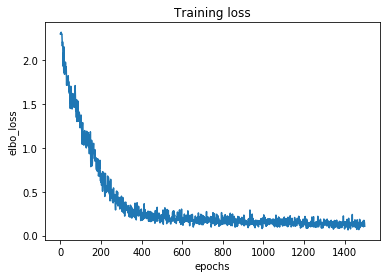

In [61]:
%matplotlib inline

# obtain the loss information of the trained model
x = np.arange( totalEpochs )
loss = modelTrainReport['m1m2m3']['label_ce'][:]
plt.plot( x, loss )

plt.xlabel('epochs')
plt.ylabel('elbo_loss')
plt.title('Training loss')


Text(0.5, 1.0, 'Training Accuracy')

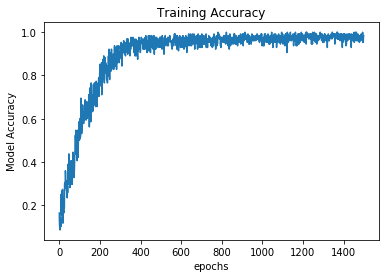

In [62]:
%matplotlib inline

# obtain the loss information of the trained model
x = np.arange( totalEpochs )
accuracy = modelTrainReport['m1m2m3']['label_acc'][:]
plt.plot( x, accuracy )

plt.xlabel('epochs')
plt.ylabel('Model Accuracy')
plt.title('Training Accuracy')


Evaluation of Model Performance on Test Dataset

**************************************** Label : 5 ****************************************
**************************************** Label : 0 ****************************************
Batch ID:  0
First Image Original : 


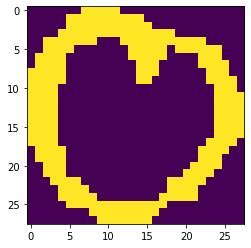

First Image Reconstructed : 


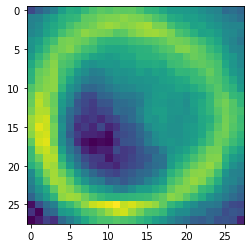

Second Image Original : 


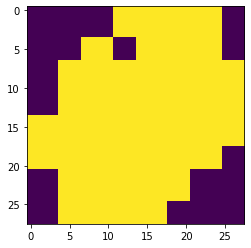

Second Image Reconstructed : 


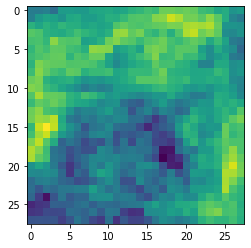

-----------------------------------------------------------------------------------------------
Batch ID:  1
First Image Original : 


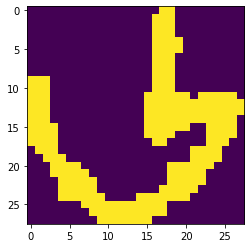

First Image Reconstructed : 


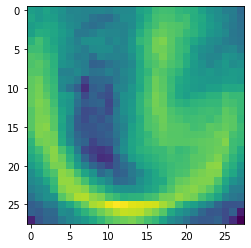

Second Image Original : 


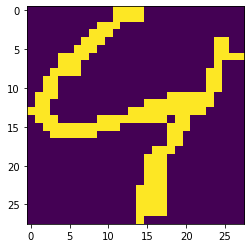

Second Image Reconstructed : 


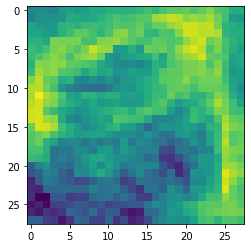

-----------------------------------------------------------------------------------------------
Batch ID:  2
First Image Original : 


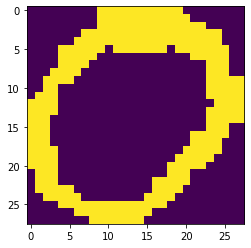

First Image Reconstructed : 


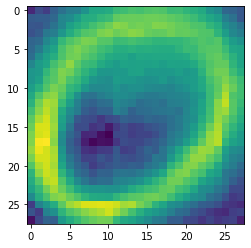

Second Image Original : 


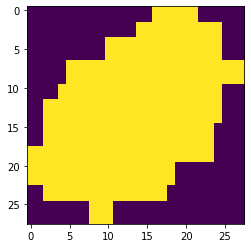

Second Image Reconstructed : 


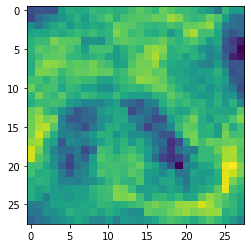

-----------------------------------------------------------------------------------------------
Batch ID:  3
First Image Original : 


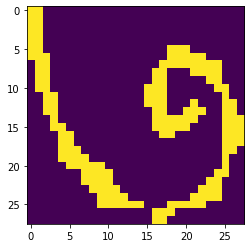

First Image Reconstructed : 


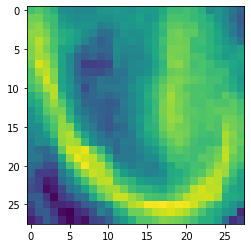

Second Image Original : 


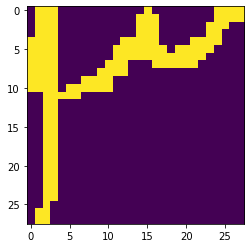

Second Image Reconstructed : 


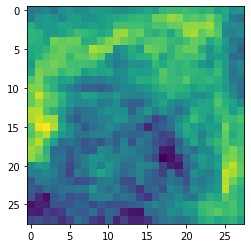

-----------------------------------------------------------------------------------------------
Batch ID:  4
First Image Original : 


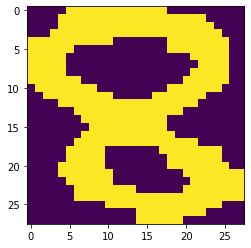

First Image Reconstructed : 


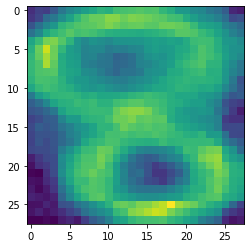

Second Image Original : 


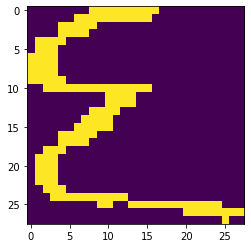

Second Image Reconstructed : 


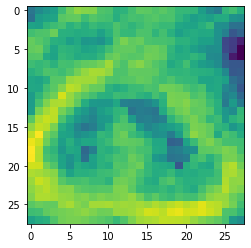

-----------------------------------------------------------------------------------------------
Batch ID:  5
First Image Original : 


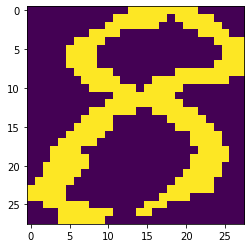

First Image Reconstructed : 


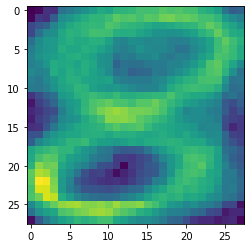

Second Image Original : 


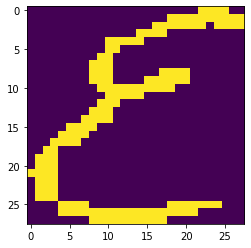

Second Image Reconstructed : 


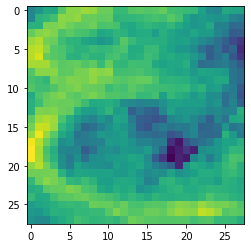

-----------------------------------------------------------------------------------------------
Batch ID:  6
First Image Original : 


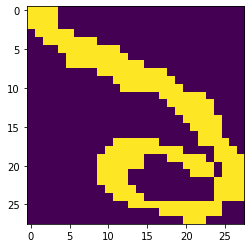

First Image Reconstructed : 


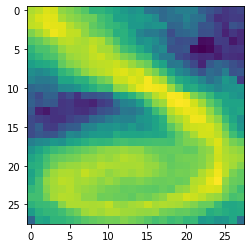

Second Image Original : 


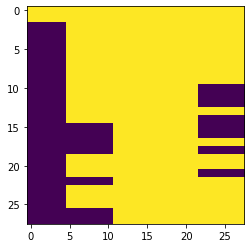

Second Image Reconstructed : 


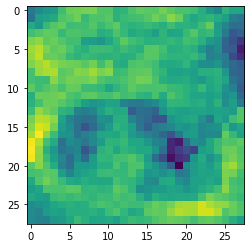

-----------------------------------------------------------------------------------------------
Batch ID:  7
First Image Original : 


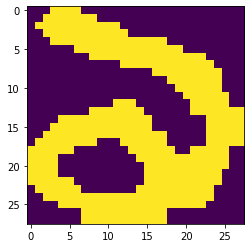

First Image Reconstructed : 


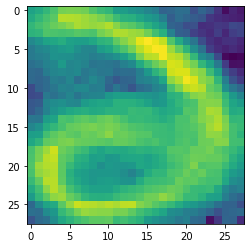

Second Image Original : 


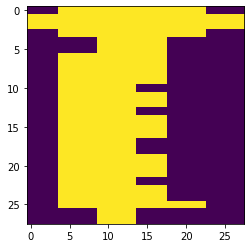

Second Image Reconstructed : 


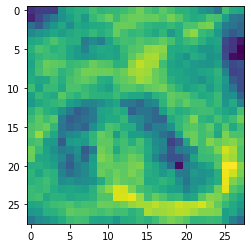

-----------------------------------------------------------------------------------------------
Batch ID:  8
First Image Original : 


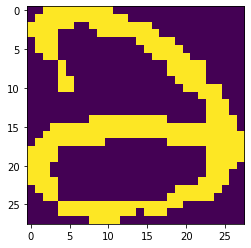

First Image Reconstructed : 


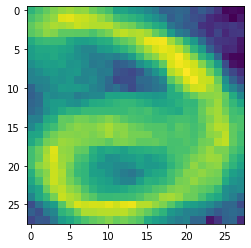

Second Image Original : 


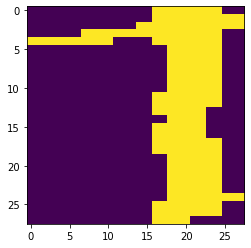

Second Image Reconstructed : 


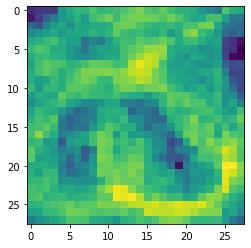

-----------------------------------------------------------------------------------------------
Batch ID:  9
First Image Original : 


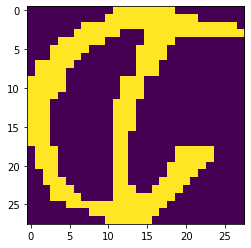

First Image Reconstructed : 


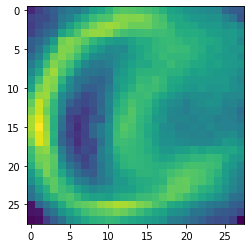

Second Image Original : 


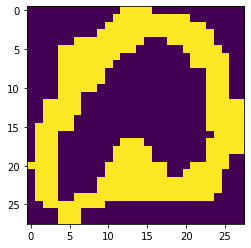

Second Image Reconstructed : 


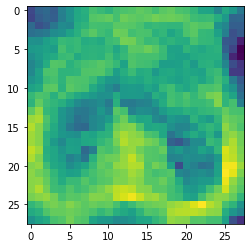

-----------------------------------------------------------------------------------------------
Batch ID:  10
First Image Original : 


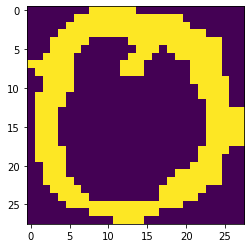

First Image Reconstructed : 


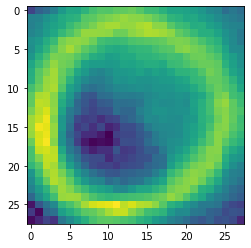

Second Image Original : 


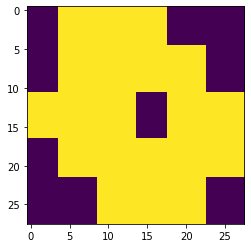

Second Image Reconstructed : 


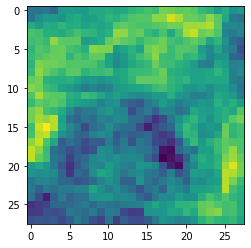

-----------------------------------------------------------------------------------------------
Batch ID:  11
First Image Original : 


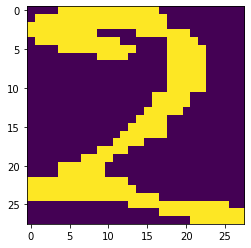

First Image Reconstructed : 


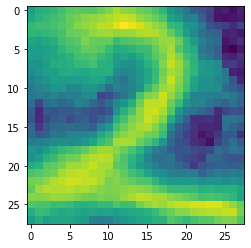

Second Image Original : 


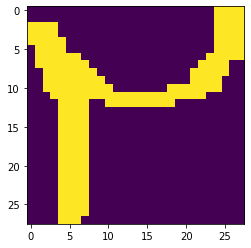

Second Image Reconstructed : 


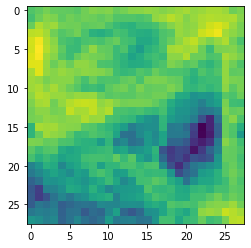

-----------------------------------------------------------------------------------------------
Batch ID:  12
First Image Original : 


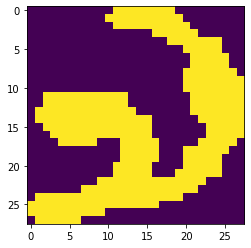

First Image Reconstructed : 


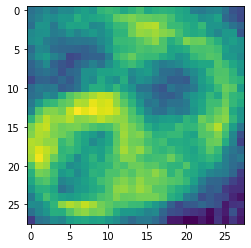

Second Image Original : 


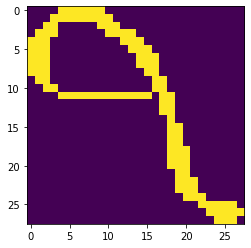

Second Image Reconstructed : 


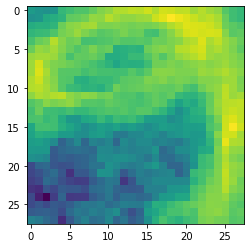

-----------------------------------------------------------------------------------------------
Batch ID:  13
First Image Original : 


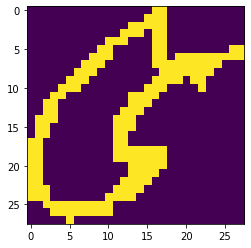

First Image Reconstructed : 


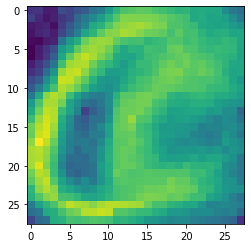

Second Image Original : 


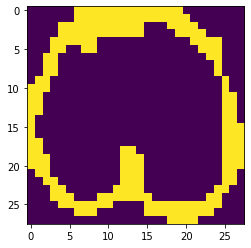

Second Image Reconstructed : 


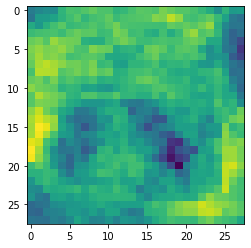

-----------------------------------------------------------------------------------------------
Batch ID:  14
First Image Original : 


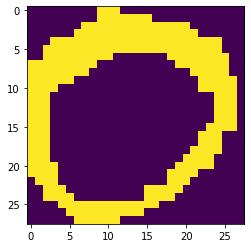

First Image Reconstructed : 


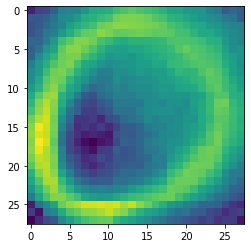

Second Image Original : 


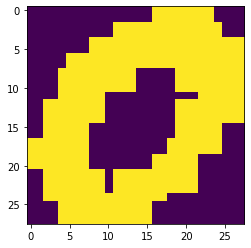

Second Image Reconstructed : 


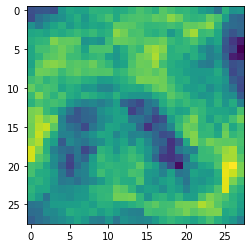

-----------------------------------------------------------------------------------------------
Batch ID:  15
First Image Original : 


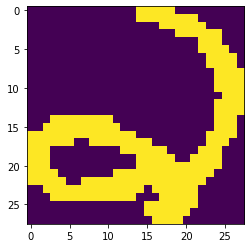

First Image Reconstructed : 


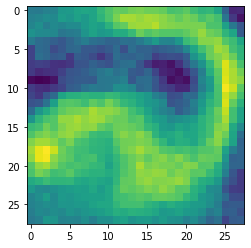

Second Image Original : 


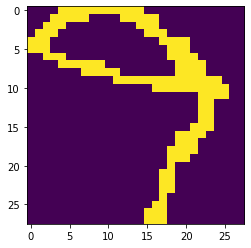

Second Image Reconstructed : 


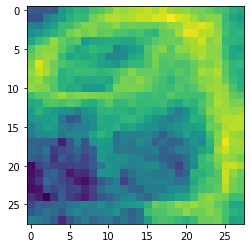

-----------------------------------------------------------------------------------------------
Batch ID:  16
First Image Original : 


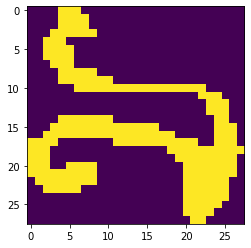

First Image Reconstructed : 


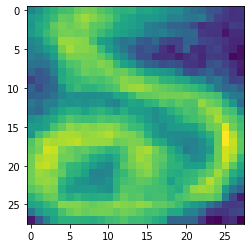

Second Image Original : 


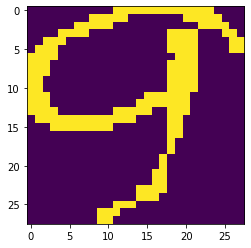

Second Image Reconstructed : 


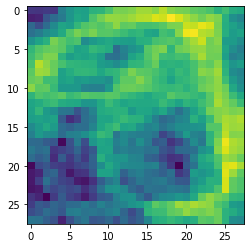

-----------------------------------------------------------------------------------------------
Batch ID:  17
First Image Original : 


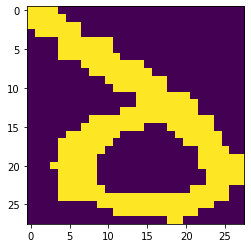

First Image Reconstructed : 


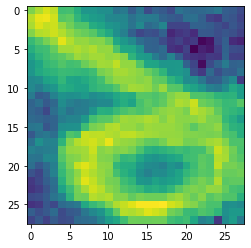

Second Image Original : 


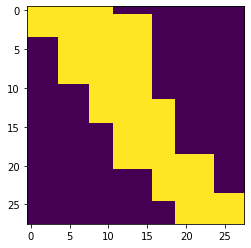

Second Image Reconstructed : 


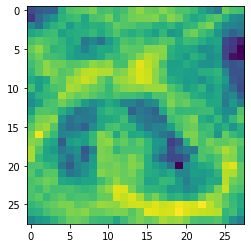

-----------------------------------------------------------------------------------------------
Batch ID:  18
First Image Original : 


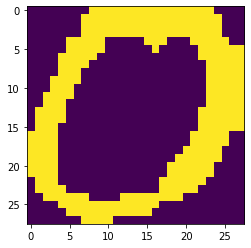

First Image Reconstructed : 


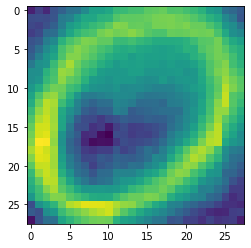

Second Image Original : 


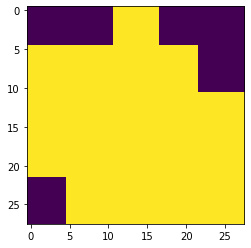

Second Image Reconstructed : 


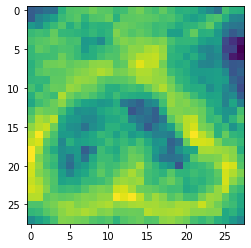

-----------------------------------------------------------------------------------------------
Batch ID:  19
First Image Original : 


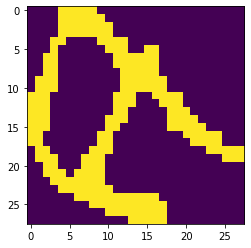

First Image Reconstructed : 


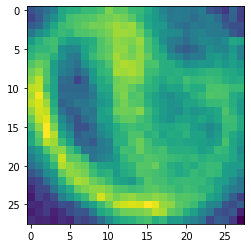

Second Image Original : 


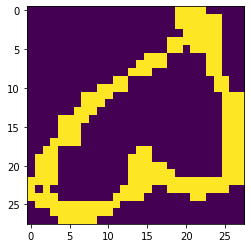

Second Image Reconstructed : 


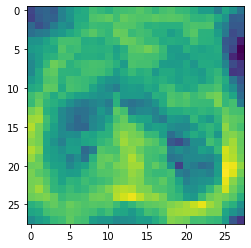

-----------------------------------------------------------------------------------------------
Batch ID:  20
First Image Original : 


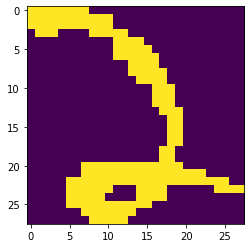

First Image Reconstructed : 


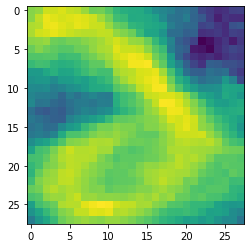

Second Image Original : 


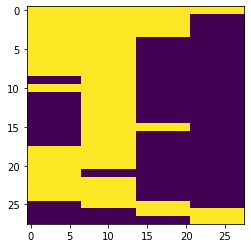

Second Image Reconstructed : 


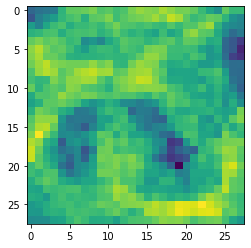

-----------------------------------------------------------------------------------------------
Batch ID:  21
First Image Original : 


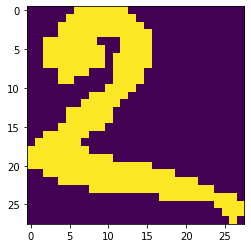

First Image Reconstructed : 


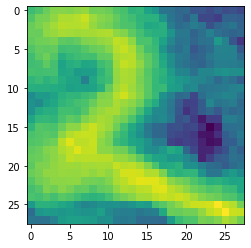

Second Image Original : 


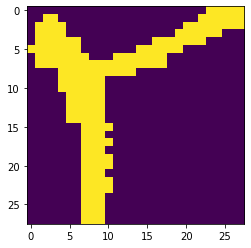

Second Image Reconstructed : 


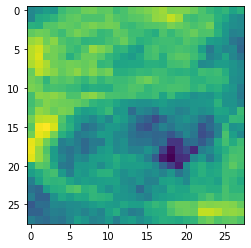

-----------------------------------------------------------------------------------------------
Batch ID:  22
First Image Original : 


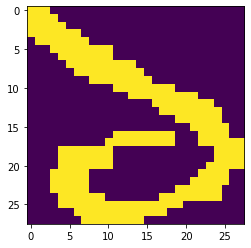

First Image Reconstructed : 


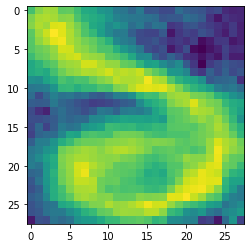

Second Image Original : 


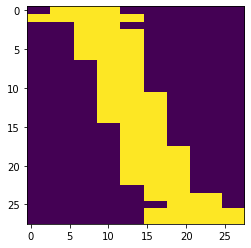

Second Image Reconstructed : 


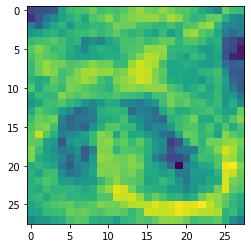

-----------------------------------------------------------------------------------------------
Batch ID:  23
First Image Original : 


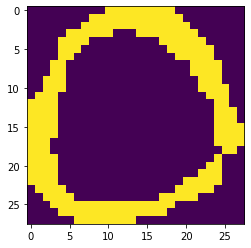

First Image Reconstructed : 


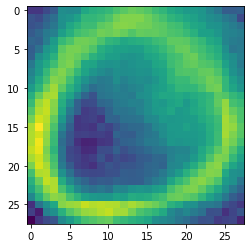

Second Image Original : 


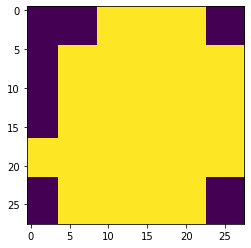

Second Image Reconstructed : 


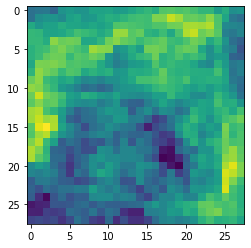

-----------------------------------------------------------------------------------------------
Batch ID:  24
First Image Original : 


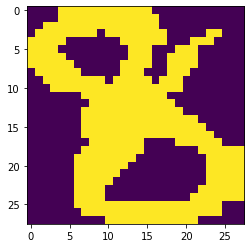

First Image Reconstructed : 


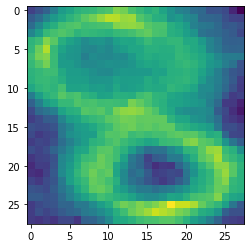

Second Image Original : 


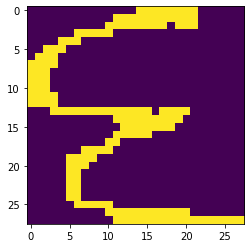

Second Image Reconstructed : 


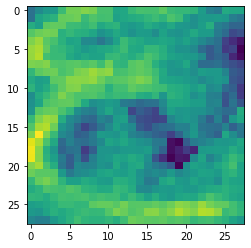

-----------------------------------------------------------------------------------------------
Batch ID:  25
First Image Original : 


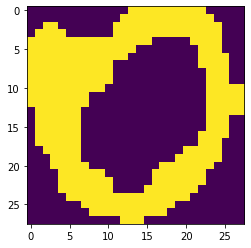

First Image Reconstructed : 


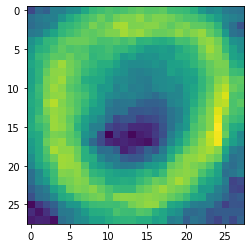

Second Image Original : 


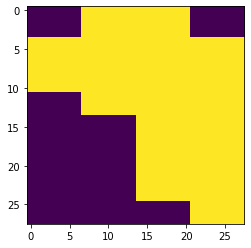

Second Image Reconstructed : 


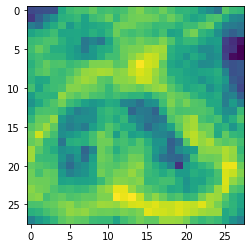

-----------------------------------------------------------------------------------------------
Batch ID:  26
First Image Original : 


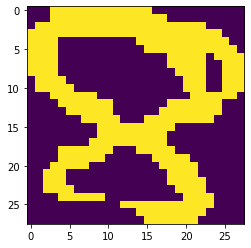

First Image Reconstructed : 


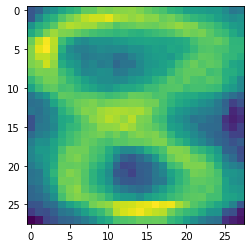

Second Image Original : 


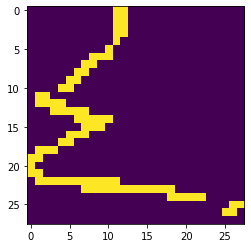

Second Image Reconstructed : 


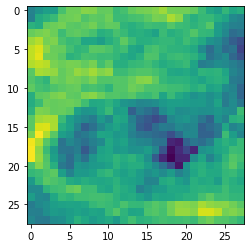

-----------------------------------------------------------------------------------------------
Batch ID:  27
First Image Original : 


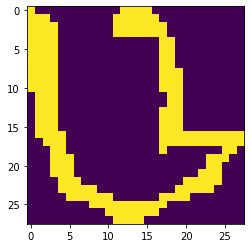

First Image Reconstructed : 


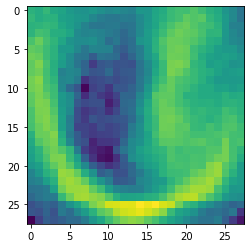

Second Image Original : 


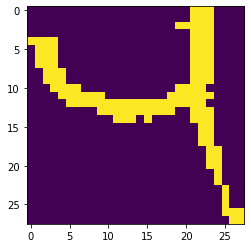

Second Image Reconstructed : 


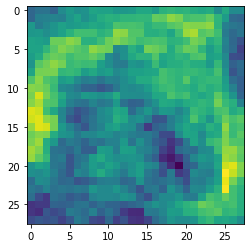

-----------------------------------------------------------------------------------------------
Batch ID:  28
First Image Original : 


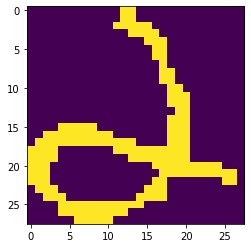

First Image Reconstructed : 


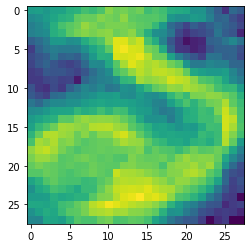

Second Image Original : 


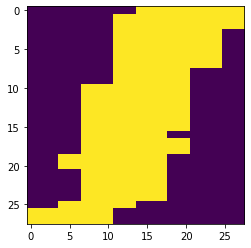

Second Image Reconstructed : 


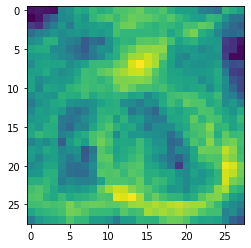

-----------------------------------------------------------------------------------------------
Batch ID:  29
First Image Original : 


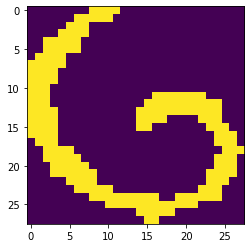

First Image Reconstructed : 


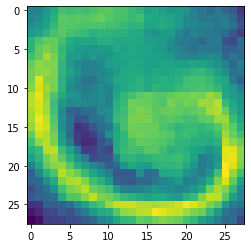

Second Image Original : 


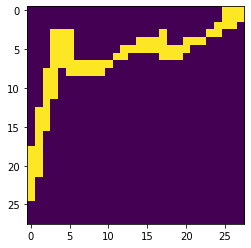

Second Image Reconstructed : 


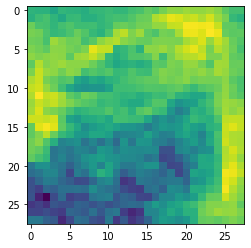

-----------------------------------------------------------------------------------------------
Batch ID:  30
First Image Original : 


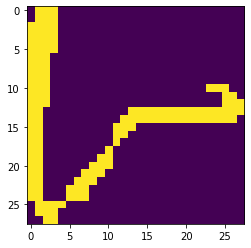

First Image Reconstructed : 


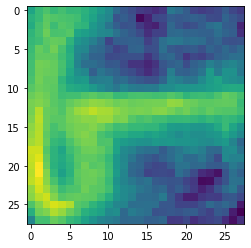

Second Image Original : 


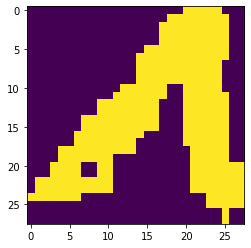

Second Image Reconstructed : 


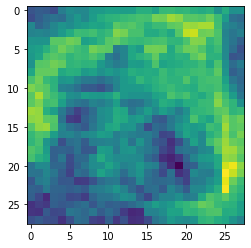

-----------------------------------------------------------------------------------------------
Batch ID:  31
First Image Original : 


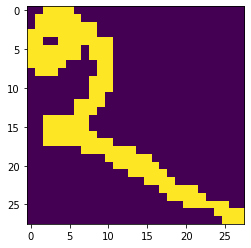

First Image Reconstructed : 


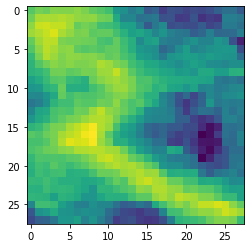

Second Image Original : 


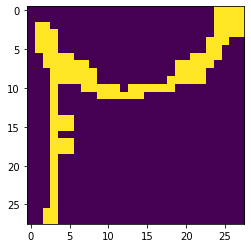

Second Image Reconstructed : 


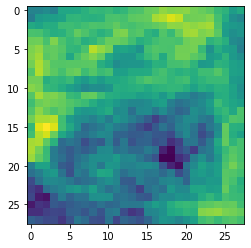

-----------------------------------------------------------------------------------------------
Batch ID:  32
First Image Original : 


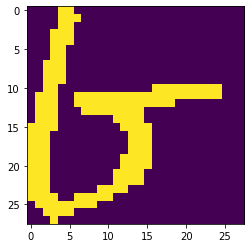

First Image Reconstructed : 


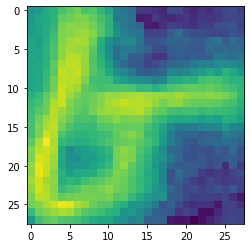

Second Image Original : 


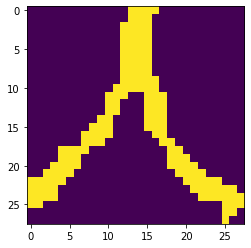

Second Image Reconstructed : 


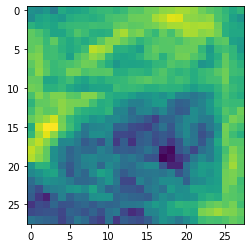

-----------------------------------------------------------------------------------------------
Batch ID:  33
First Image Original : 


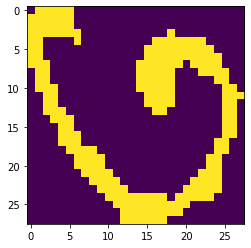

First Image Reconstructed : 


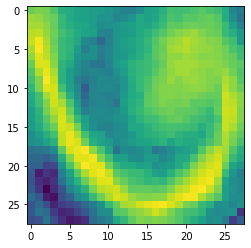

Second Image Original : 


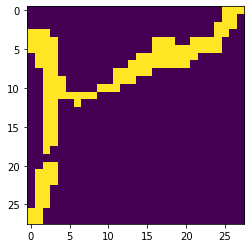

Second Image Reconstructed : 


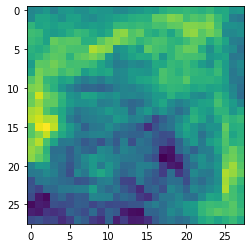

-----------------------------------------------------------------------------------------------
Batch ID:  34
First Image Original : 


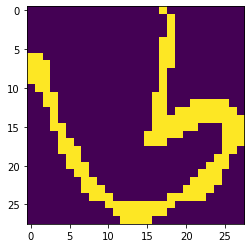

First Image Reconstructed : 


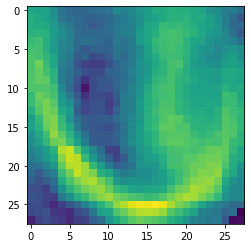

Second Image Original : 


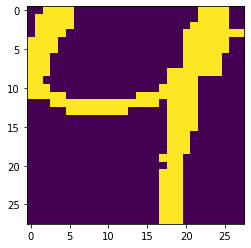

Second Image Reconstructed : 


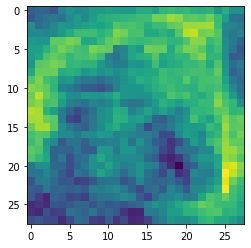

-----------------------------------------------------------------------------------------------
Batch ID:  35
First Image Original : 


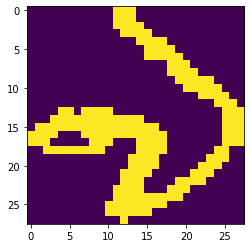

First Image Reconstructed : 


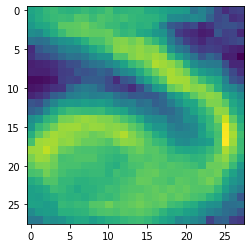

Second Image Original : 


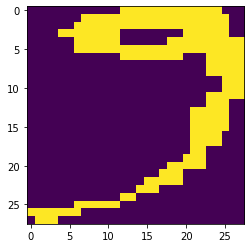

Second Image Reconstructed : 


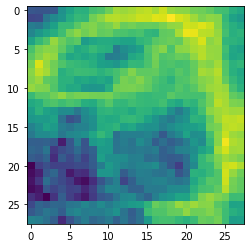

-----------------------------------------------------------------------------------------------
Batch ID:  36
First Image Original : 


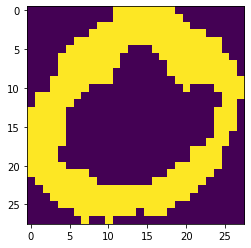

First Image Reconstructed : 


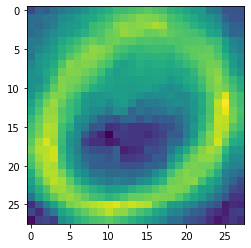

Second Image Original : 


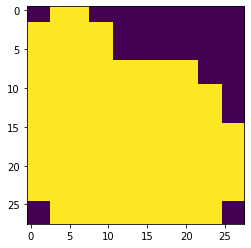

Second Image Reconstructed : 


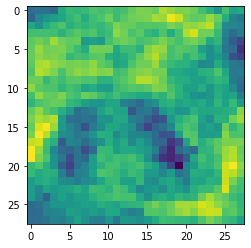

-----------------------------------------------------------------------------------------------
Batch ID:  37
First Image Original : 


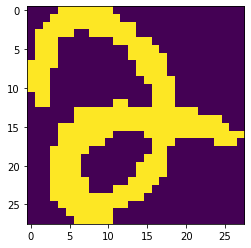

First Image Reconstructed : 


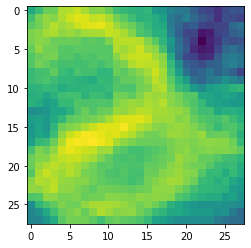

Second Image Original : 


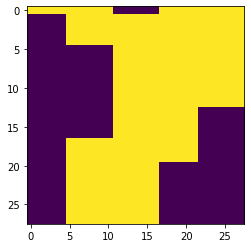

Second Image Reconstructed : 


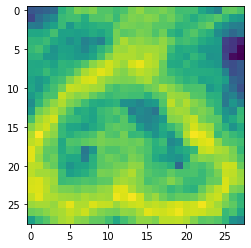

-----------------------------------------------------------------------------------------------
Batch ID:  38
First Image Original : 


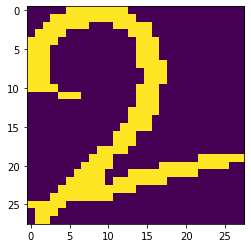

First Image Reconstructed : 


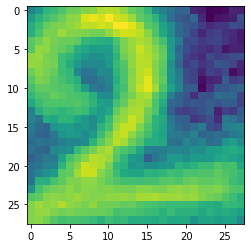

Second Image Original : 


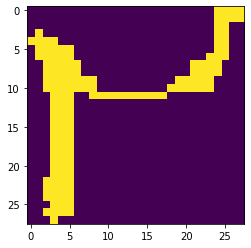

Second Image Reconstructed : 


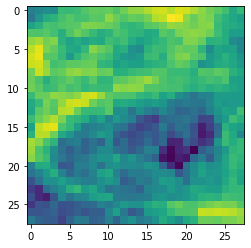

-----------------------------------------------------------------------------------------------
Batch ID:  39
First Image Original : 


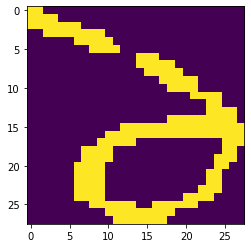

First Image Reconstructed : 


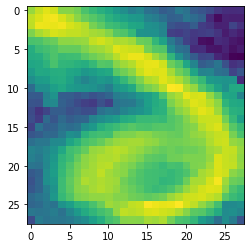

Second Image Original : 


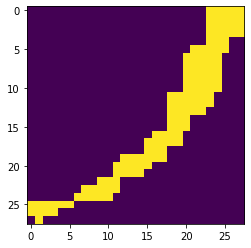

Second Image Reconstructed : 


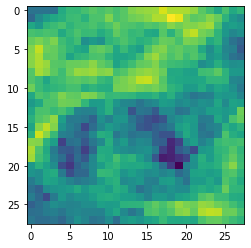

-----------------------------------------------------------------------------------------------
Batch ID:  40
First Image Original : 


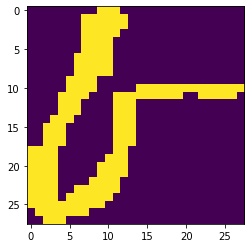

First Image Reconstructed : 


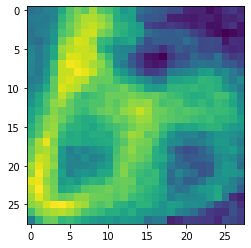

Second Image Original : 


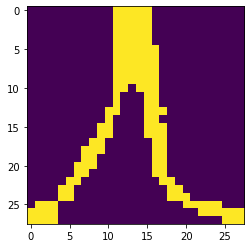

Second Image Reconstructed : 


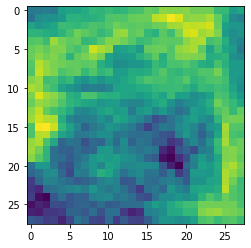

-----------------------------------------------------------------------------------------------
Batch ID:  41
First Image Original : 


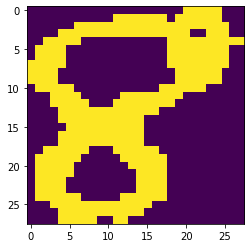

First Image Reconstructed : 


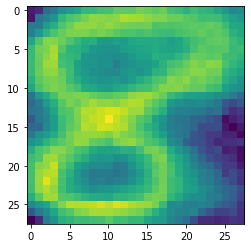

Second Image Original : 


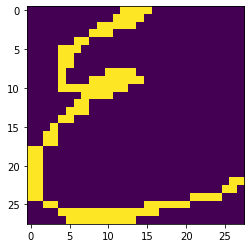

Second Image Reconstructed : 


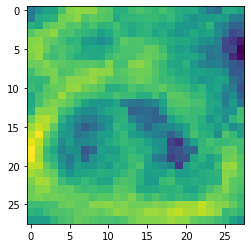

-----------------------------------------------------------------------------------------------
Batch ID:  42
First Image Original : 


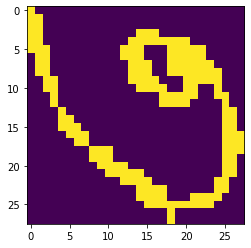

First Image Reconstructed : 


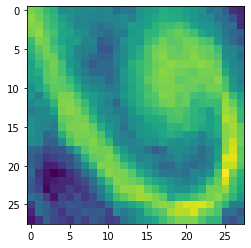

Second Image Original : 


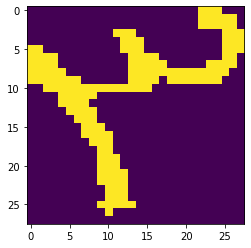

Second Image Reconstructed : 


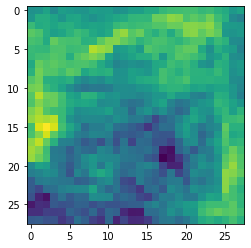

-----------------------------------------------------------------------------------------------
Batch ID:  43
First Image Original : 


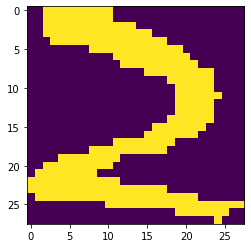

First Image Reconstructed : 


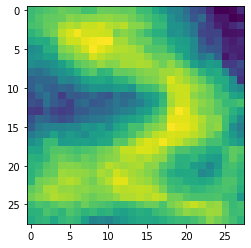

Second Image Original : 


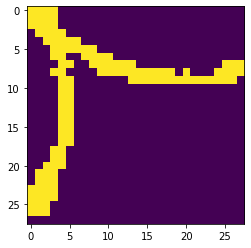

Second Image Reconstructed : 


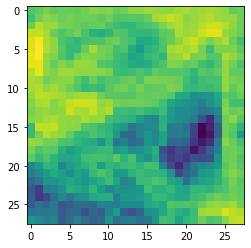

-----------------------------------------------------------------------------------------------
Batch ID:  44
First Image Original : 


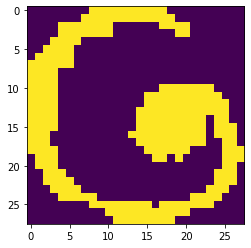

First Image Reconstructed : 


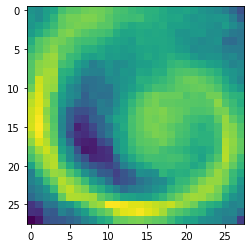

Second Image Original : 


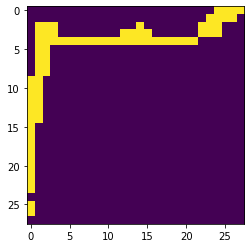

Second Image Reconstructed : 


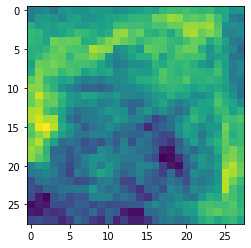

-----------------------------------------------------------------------------------------------
Batch ID:  45
First Image Original : 


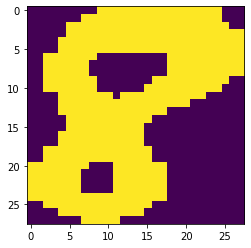

First Image Reconstructed : 


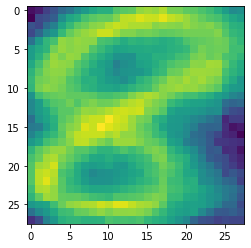

Second Image Original : 


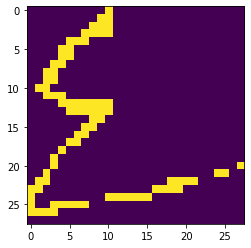

Second Image Reconstructed : 


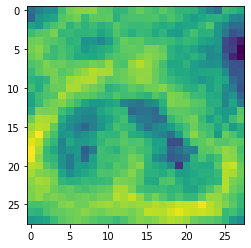

-----------------------------------------------------------------------------------------------
Batch ID:  46
First Image Original : 


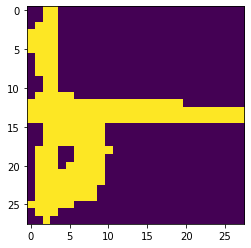

First Image Reconstructed : 


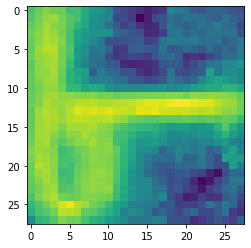

Second Image Original : 


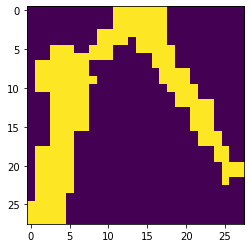

Second Image Reconstructed : 


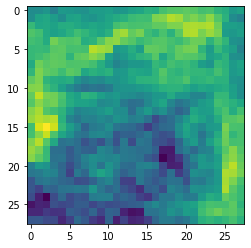

-----------------------------------------------------------------------------------------------
Batch ID:  47
First Image Original : 


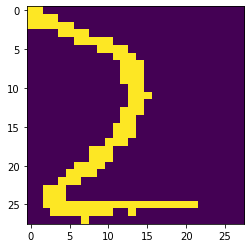

First Image Reconstructed : 


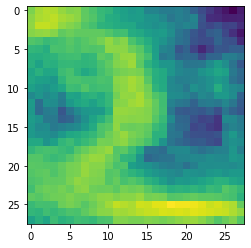

Second Image Original : 


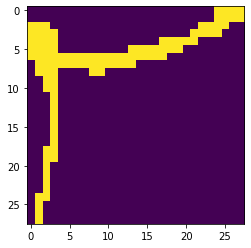

Second Image Reconstructed : 


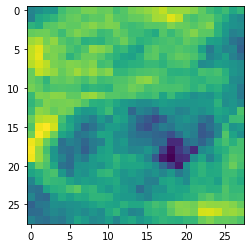

-----------------------------------------------------------------------------------------------
Batch ID:  48
First Image Original : 


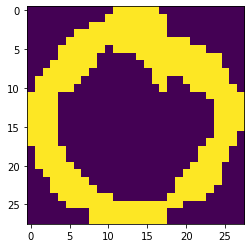

First Image Reconstructed : 


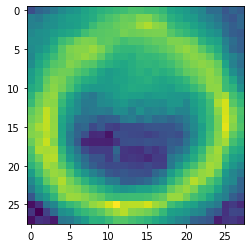

Second Image Original : 


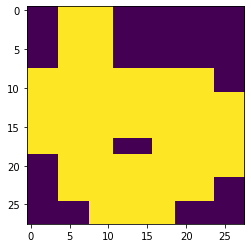

Second Image Reconstructed : 


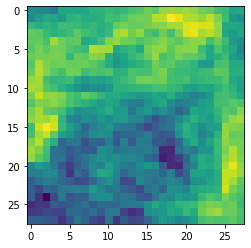

-----------------------------------------------------------------------------------------------
Batch ID:  49
First Image Original : 


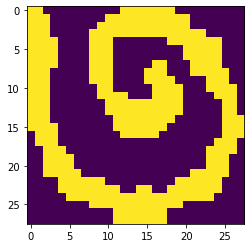

First Image Reconstructed : 


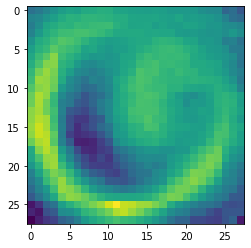

Second Image Original : 


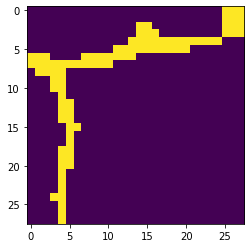

Second Image Reconstructed : 


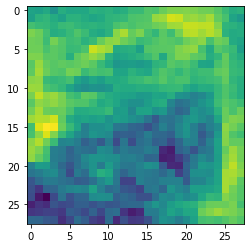

-----------------------------------------------------------------------------------------------
Batch ID:  50
First Image Original : 


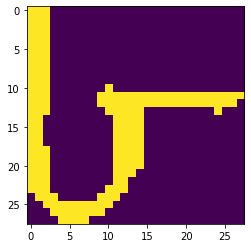

First Image Reconstructed : 


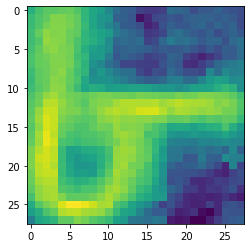

Second Image Original : 


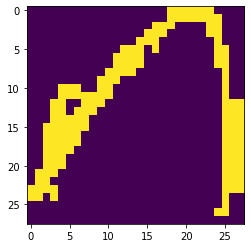

Second Image Reconstructed : 


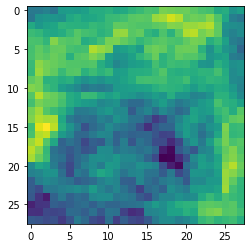

-----------------------------------------------------------------------------------------------
Batch ID:  51
First Image Original : 


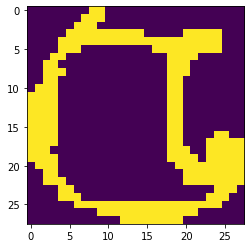

First Image Reconstructed : 


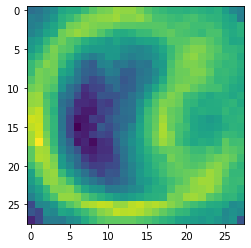

Second Image Original : 


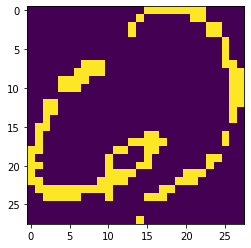

Second Image Reconstructed : 


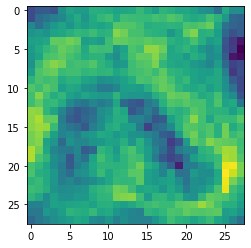

-----------------------------------------------------------------------------------------------
Batch ID:  52
First Image Original : 


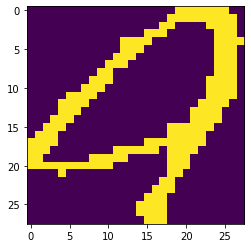

First Image Reconstructed : 


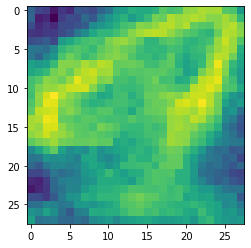

Second Image Original : 


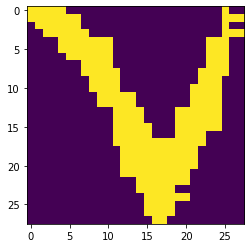

Second Image Reconstructed : 


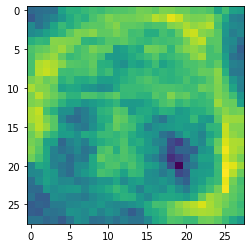

-----------------------------------------------------------------------------------------------
Batch ID:  53
First Image Original : 


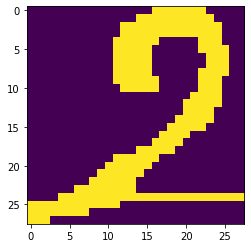

First Image Reconstructed : 


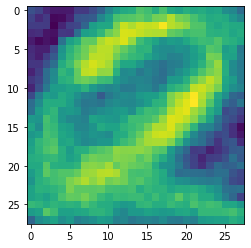

Second Image Original : 


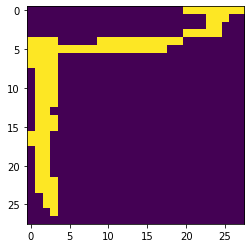

Second Image Reconstructed : 


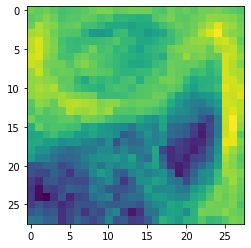

-----------------------------------------------------------------------------------------------
Batch ID:  54
First Image Original : 


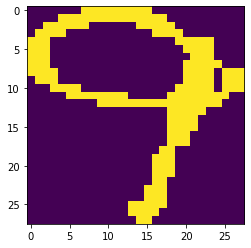

First Image Reconstructed : 


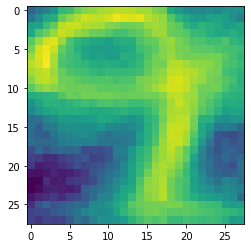

Second Image Original : 


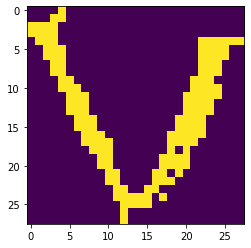

Second Image Reconstructed : 


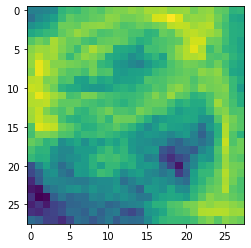

-----------------------------------------------------------------------------------------------
Batch ID:  55
First Image Original : 


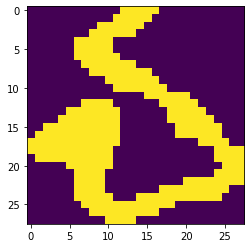

First Image Reconstructed : 


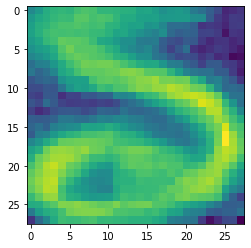

Second Image Original : 


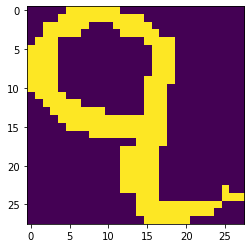

Second Image Reconstructed : 


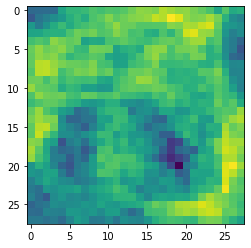

-----------------------------------------------------------------------------------------------
Batch ID:  56
First Image Original : 


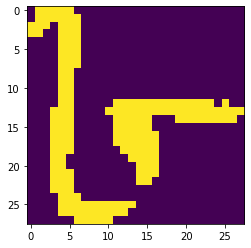

First Image Reconstructed : 


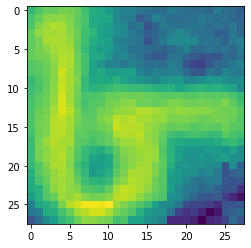

Second Image Original : 


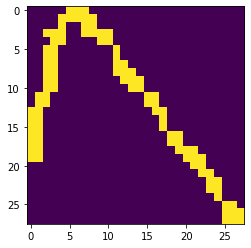

Second Image Reconstructed : 


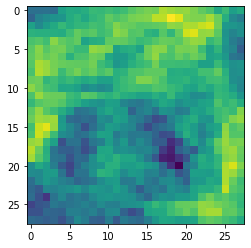

-----------------------------------------------------------------------------------------------
Batch ID:  57
First Image Original : 


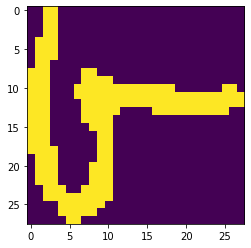

First Image Reconstructed : 


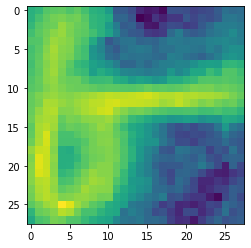

Second Image Original : 


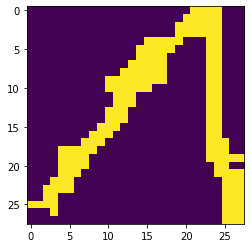

Second Image Reconstructed : 


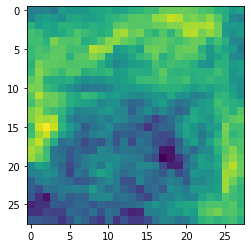

-----------------------------------------------------------------------------------------------
Batch ID:  58
First Image Original : 


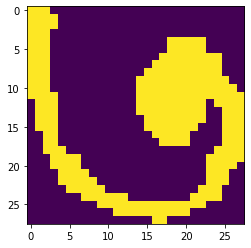

First Image Reconstructed : 


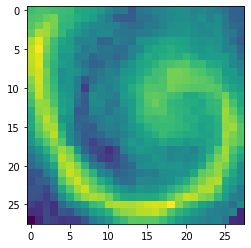

Second Image Original : 


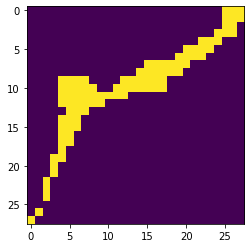

Second Image Reconstructed : 


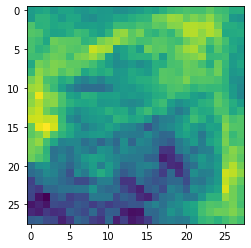

-----------------------------------------------------------------------------------------------
Batch ID:  59
First Image Original : 


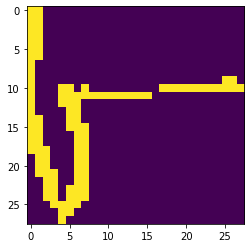

First Image Reconstructed : 


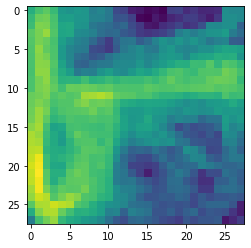

Second Image Original : 


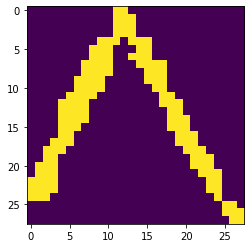

Second Image Reconstructed : 


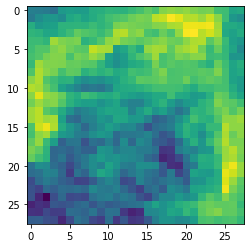

-----------------------------------------------------------------------------------------------
Batch ID:  60
First Image Original : 


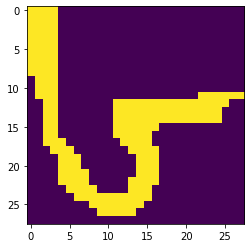

First Image Reconstructed : 


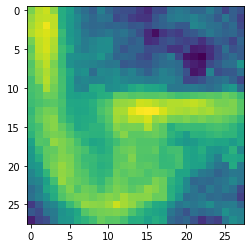

Second Image Original : 


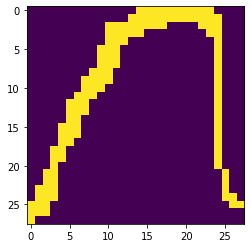

Second Image Reconstructed : 


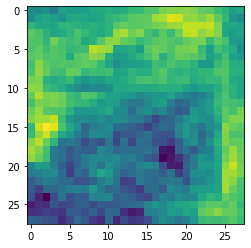

-----------------------------------------------------------------------------------------------
Batch ID:  61
First Image Original : 


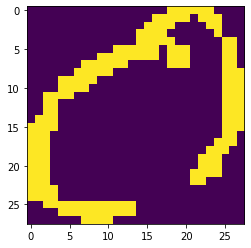

First Image Reconstructed : 


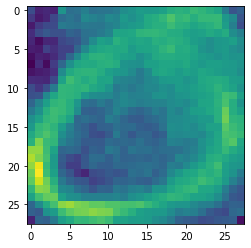

Second Image Original : 


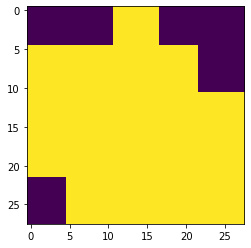

Second Image Reconstructed : 


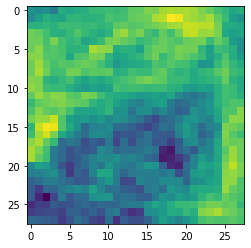

-----------------------------------------------------------------------------------------------
Batch ID:  62
First Image Original : 


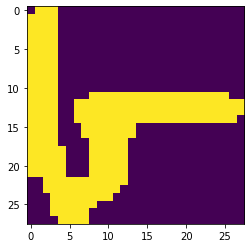

First Image Reconstructed : 


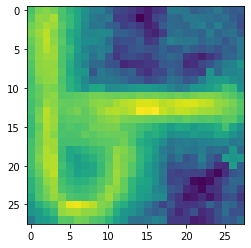

Second Image Original : 


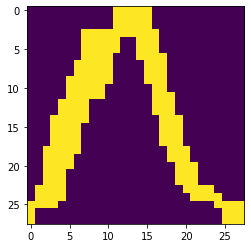

Second Image Reconstructed : 


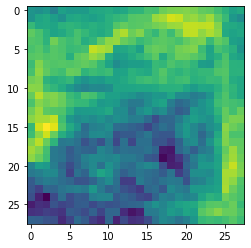

-----------------------------------------------------------------------------------------------
Batch ID:  63
First Image Original : 


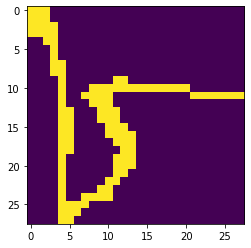

First Image Reconstructed : 


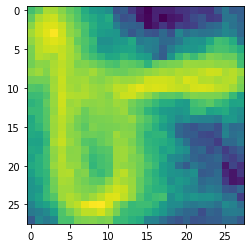

Second Image Original : 


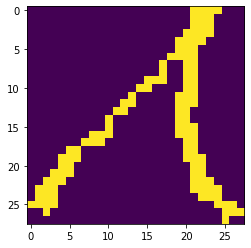

Second Image Reconstructed : 


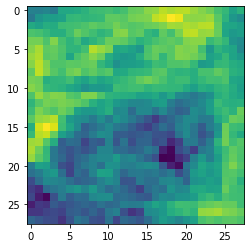

-----------------------------------------------------------------------------------------------
Batch ID:  64
First Image Original : 


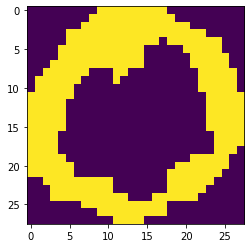

First Image Reconstructed : 


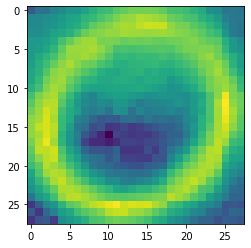

Second Image Original : 


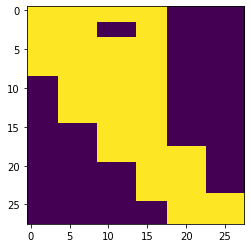

Second Image Reconstructed : 


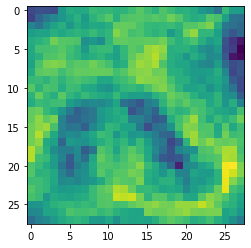

-----------------------------------------------------------------------------------------------
Batch ID:  65
First Image Original : 


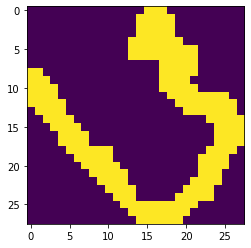

First Image Reconstructed : 


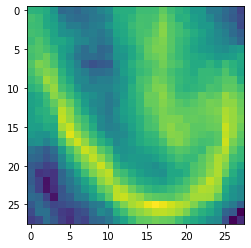

Second Image Original : 


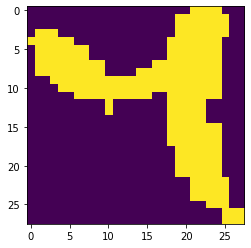

Second Image Reconstructed : 


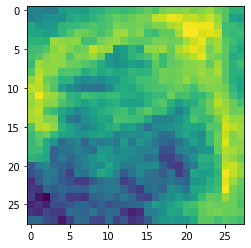

-----------------------------------------------------------------------------------------------
Batch ID:  66
First Image Original : 


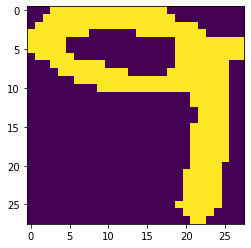

First Image Reconstructed : 


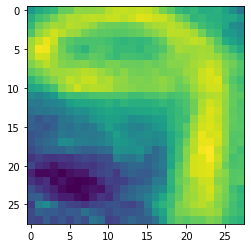

Second Image Original : 


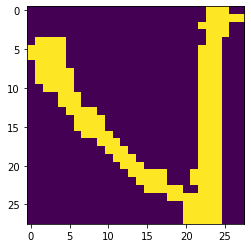

Second Image Reconstructed : 


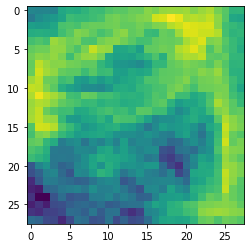

-----------------------------------------------------------------------------------------------
Batch ID:  67
First Image Original : 


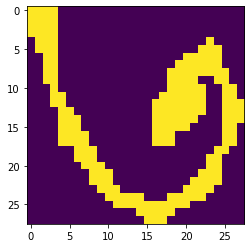

First Image Reconstructed : 


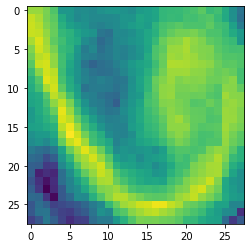

Second Image Original : 


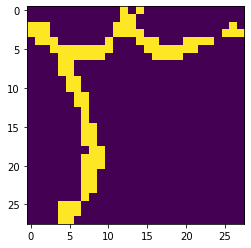

Second Image Reconstructed : 


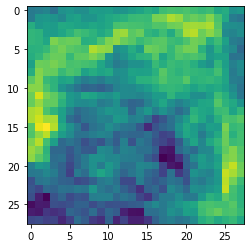

-----------------------------------------------------------------------------------------------
Batch ID:  68
First Image Original : 


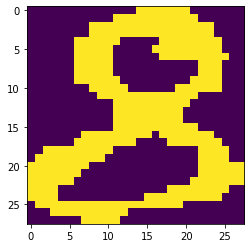

First Image Reconstructed : 


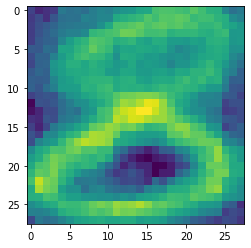

Second Image Original : 


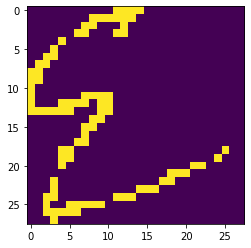

Second Image Reconstructed : 


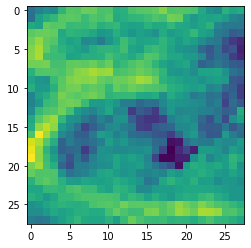

-----------------------------------------------------------------------------------------------
Batch ID:  69
First Image Original : 


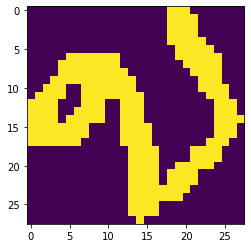

First Image Reconstructed : 


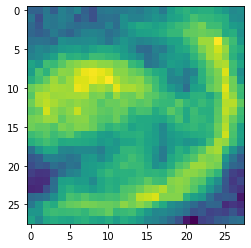

Second Image Original : 


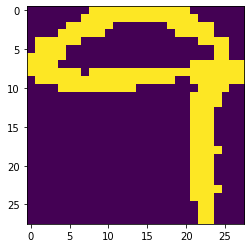

Second Image Reconstructed : 


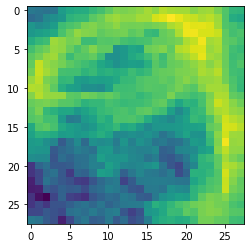

-----------------------------------------------------------------------------------------------
Batch ID:  70
First Image Original : 


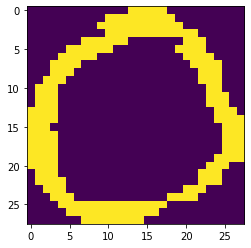

First Image Reconstructed : 


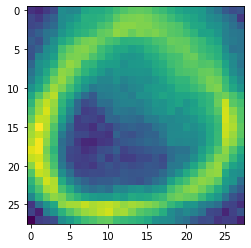

Second Image Original : 


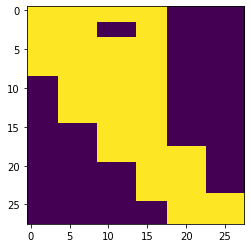

Second Image Reconstructed : 


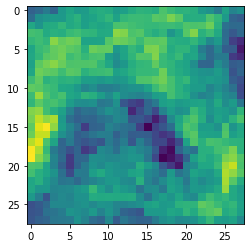

-----------------------------------------------------------------------------------------------
Batch ID:  71
First Image Original : 


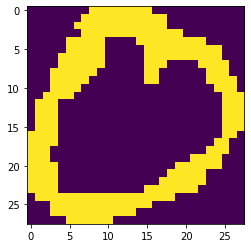

First Image Reconstructed : 


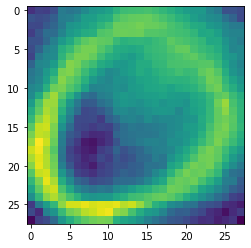

Second Image Original : 


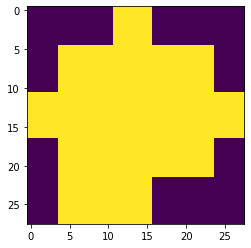

Second Image Reconstructed : 


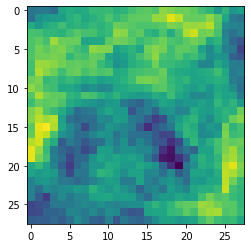

-----------------------------------------------------------------------------------------------
Batch ID:  72
First Image Original : 


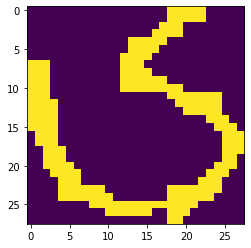

First Image Reconstructed : 


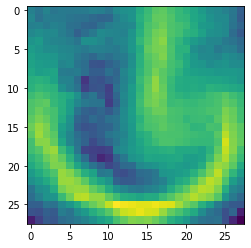

Second Image Original : 


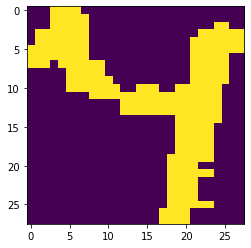

Second Image Reconstructed : 


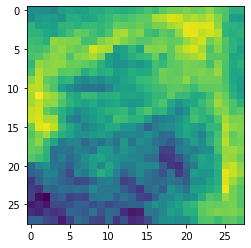

-----------------------------------------------------------------------------------------------
Batch ID:  73
First Image Original : 


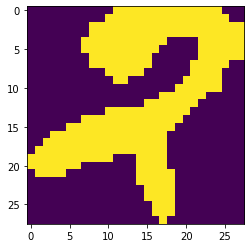

First Image Reconstructed : 


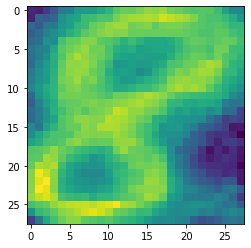

Second Image Original : 


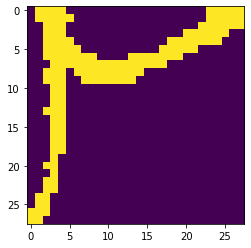

Second Image Reconstructed : 


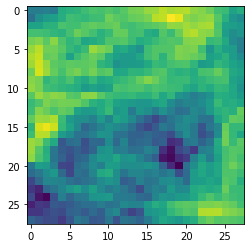

-----------------------------------------------------------------------------------------------
Batch ID:  74
First Image Original : 


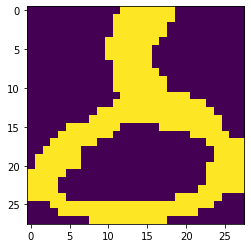

First Image Reconstructed : 


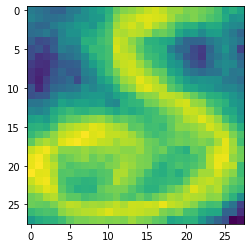

Second Image Original : 


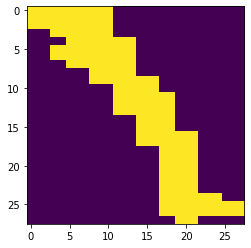

Second Image Reconstructed : 


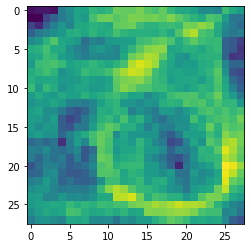

-----------------------------------------------------------------------------------------------
Batch ID:  75
First Image Original : 


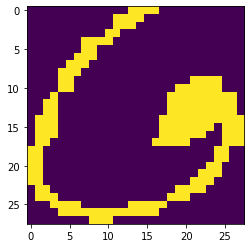

First Image Reconstructed : 


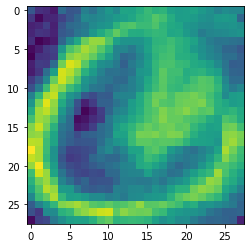

Second Image Original : 


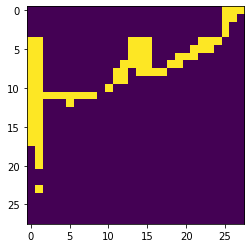

Second Image Reconstructed : 


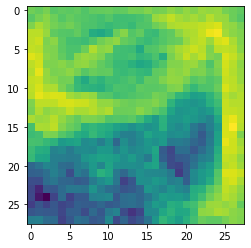

-----------------------------------------------------------------------------------------------
Batch ID:  76
First Image Original : 


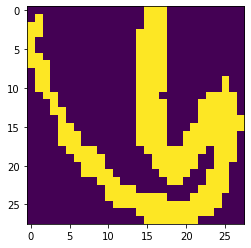

First Image Reconstructed : 


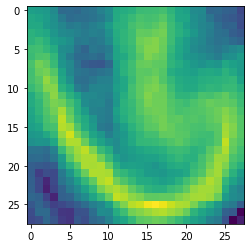

Second Image Original : 


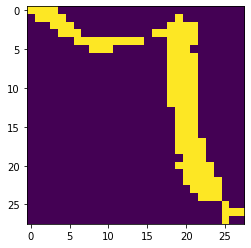

Second Image Reconstructed : 


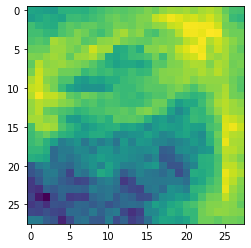

-----------------------------------------------------------------------------------------------
Batch ID:  77
First Image Original : 


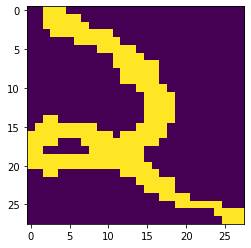

First Image Reconstructed : 


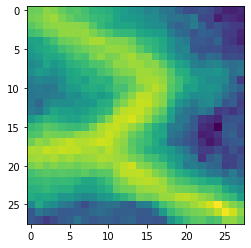

Second Image Original : 


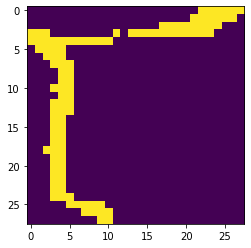

Second Image Reconstructed : 


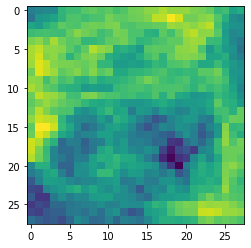

-----------------------------------------------------------------------------------------------
Batch ID:  78
First Image Original : 


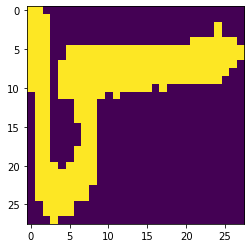

First Image Reconstructed : 


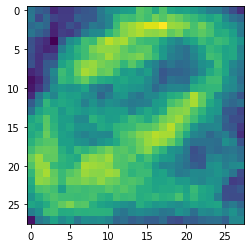

Second Image Original : 


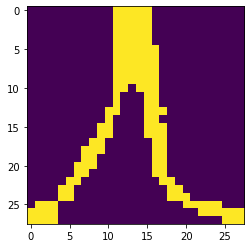

Second Image Reconstructed : 


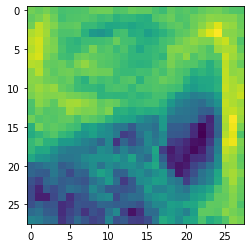

-----------------------------------------------------------------------------------------------
Batch ID:  79
First Image Original : 


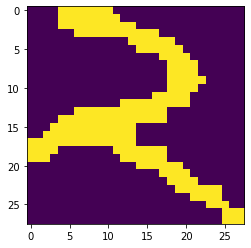

First Image Reconstructed : 


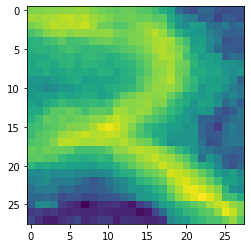

Second Image Original : 


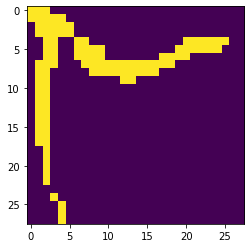

Second Image Reconstructed : 


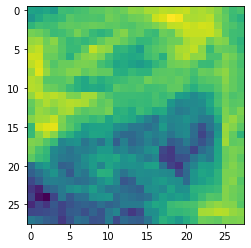

-----------------------------------------------------------------------------------------------
Batch ID:  80
First Image Original : 


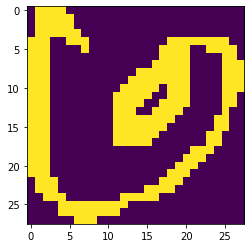

First Image Reconstructed : 


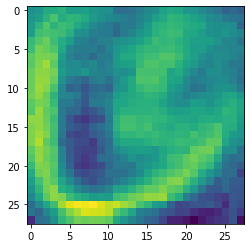

Second Image Original : 


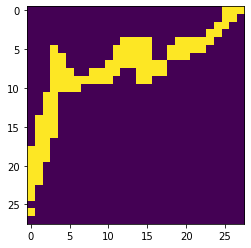

Second Image Reconstructed : 


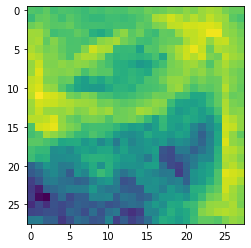

-----------------------------------------------------------------------------------------------
Batch ID:  81
First Image Original : 


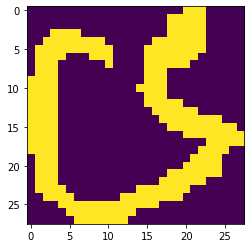

First Image Reconstructed : 


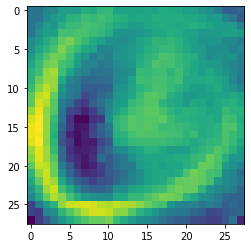

Second Image Original : 


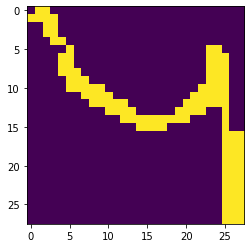

Second Image Reconstructed : 


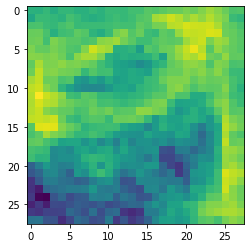

-----------------------------------------------------------------------------------------------
Batch ID:  82
First Image Original : 


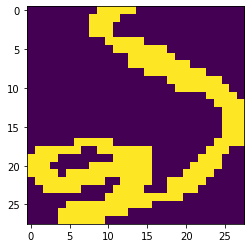

First Image Reconstructed : 


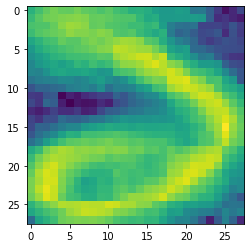

Second Image Original : 


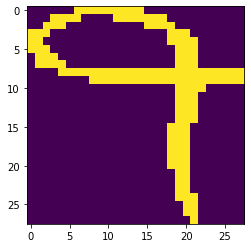

Second Image Reconstructed : 


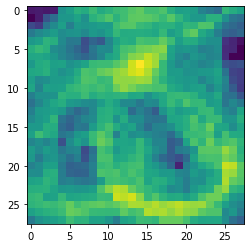

-----------------------------------------------------------------------------------------------
Batch ID:  83
First Image Original : 


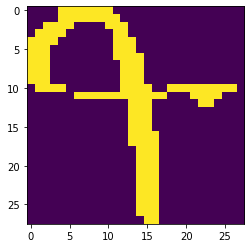

First Image Reconstructed : 


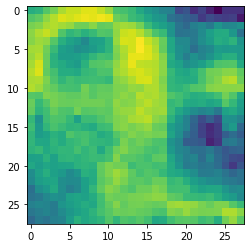

Second Image Original : 


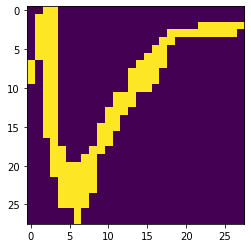

Second Image Reconstructed : 


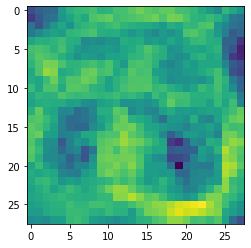

-----------------------------------------------------------------------------------------------
Batch ID:  84
First Image Original : 


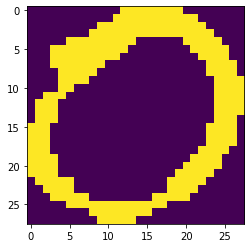

First Image Reconstructed : 


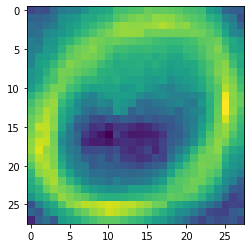

Second Image Original : 


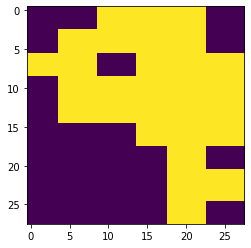

Second Image Reconstructed : 


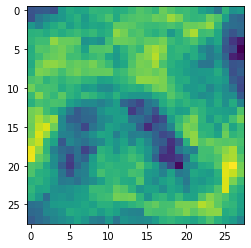

-----------------------------------------------------------------------------------------------
Batch ID:  85
First Image Original : 


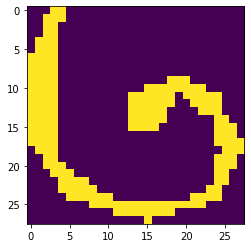

First Image Reconstructed : 


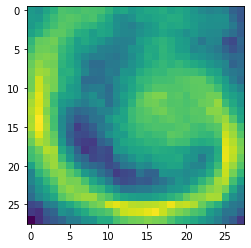

Second Image Original : 


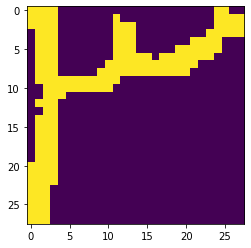

Second Image Reconstructed : 


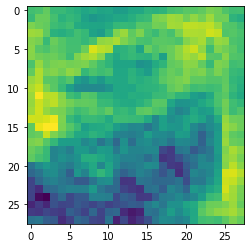

-----------------------------------------------------------------------------------------------
Batch ID:  86
First Image Original : 


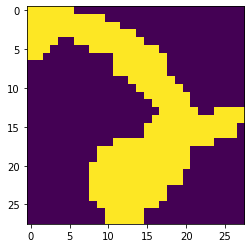

First Image Reconstructed : 


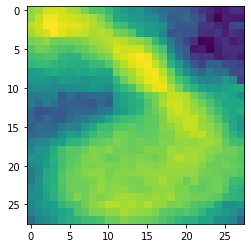

Second Image Original : 


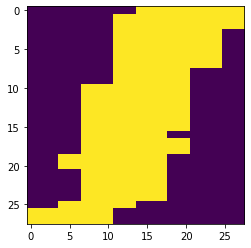

Second Image Reconstructed : 


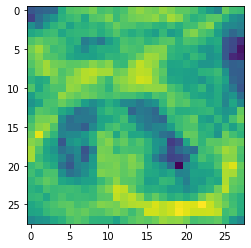

-----------------------------------------------------------------------------------------------
Batch ID:  87
First Image Original : 


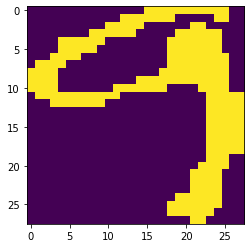

First Image Reconstructed : 


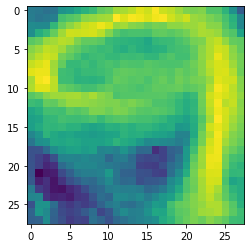

Second Image Original : 


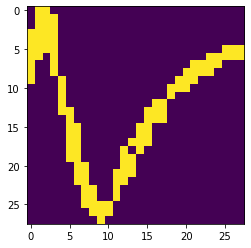

Second Image Reconstructed : 


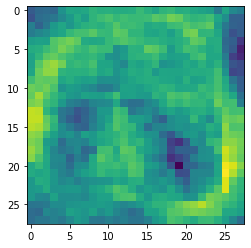

-----------------------------------------------------------------------------------------------
Batch ID:  88
First Image Original : 


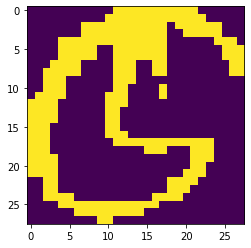

First Image Reconstructed : 


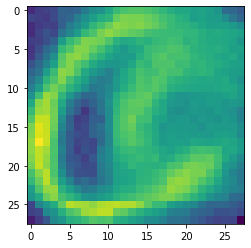

Second Image Original : 


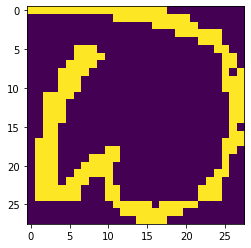

Second Image Reconstructed : 


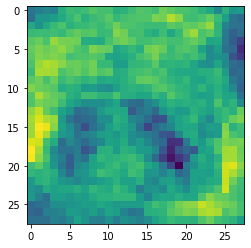

-----------------------------------------------------------------------------------------------
Batch ID:  89
First Image Original : 


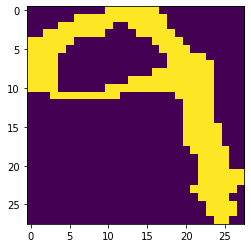

First Image Reconstructed : 


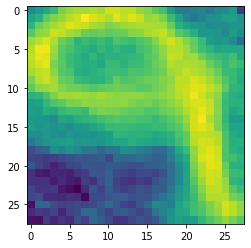

Second Image Original : 


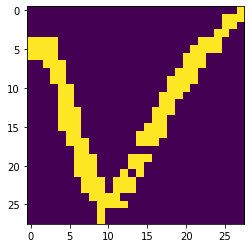

Second Image Reconstructed : 


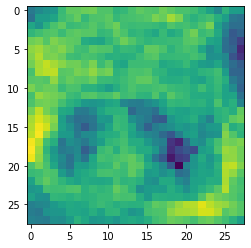

-----------------------------------------------------------------------------------------------
Batch ID:  90
First Image Original : 


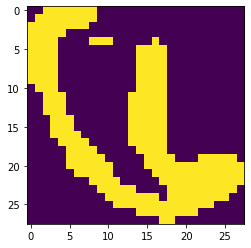

First Image Reconstructed : 


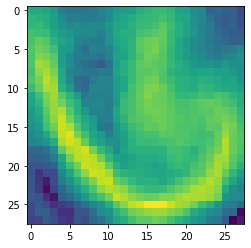

Second Image Original : 


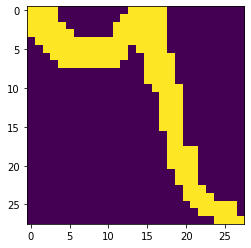

Second Image Reconstructed : 


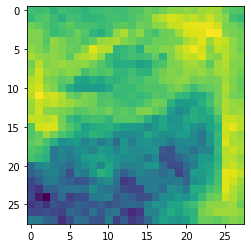

-----------------------------------------------------------------------------------------------
Batch ID:  91
First Image Original : 


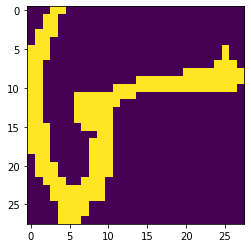

First Image Reconstructed : 


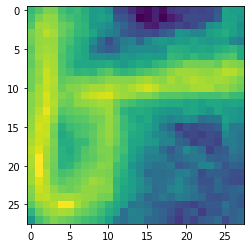

Second Image Original : 


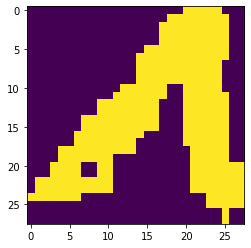

Second Image Reconstructed : 


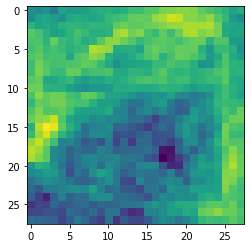

-----------------------------------------------------------------------------------------------
Batch ID:  92
First Image Original : 


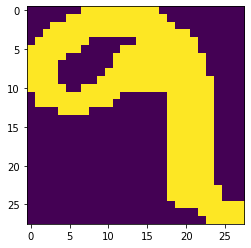

First Image Reconstructed : 


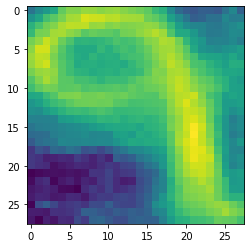

Second Image Original : 


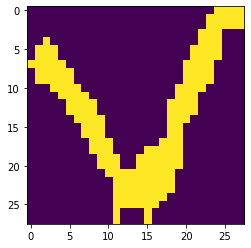

Second Image Reconstructed : 


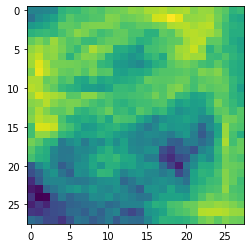

-----------------------------------------------------------------------------------------------
Batch ID:  93
First Image Original : 


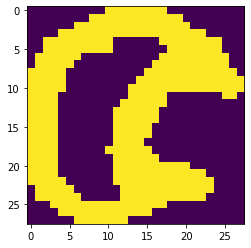

First Image Reconstructed : 


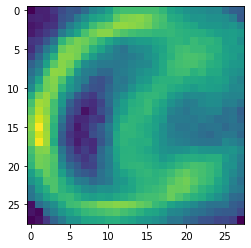

Second Image Original : 


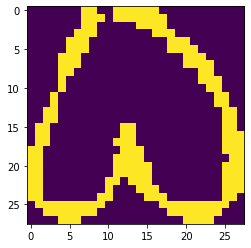

Second Image Reconstructed : 


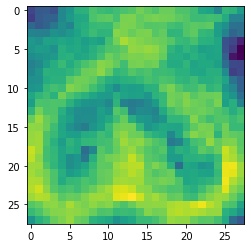

-----------------------------------------------------------------------------------------------
Batch ID:  94
First Image Original : 


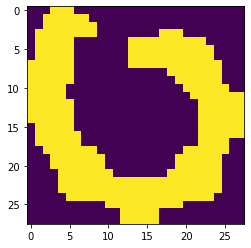

First Image Reconstructed : 


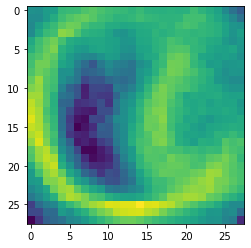

Second Image Original : 


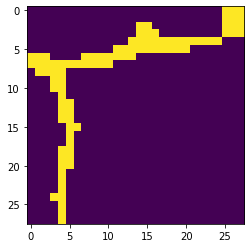

Second Image Reconstructed : 


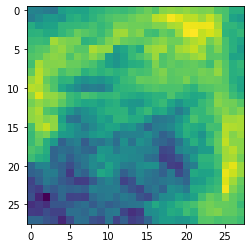

-----------------------------------------------------------------------------------------------
Batch ID:  95
First Image Original : 


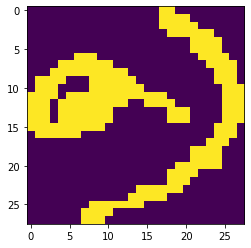

First Image Reconstructed : 


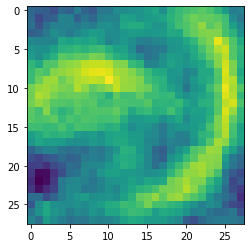

Second Image Original : 


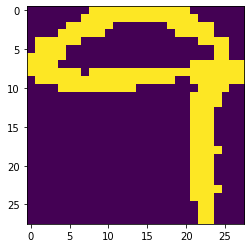

Second Image Reconstructed : 


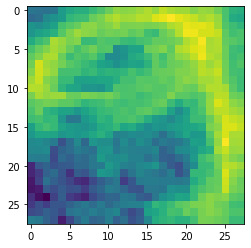

-----------------------------------------------------------------------------------------------
Batch ID:  96
First Image Original : 


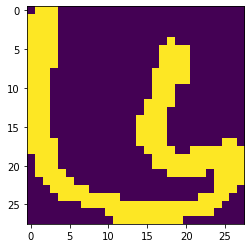

First Image Reconstructed : 


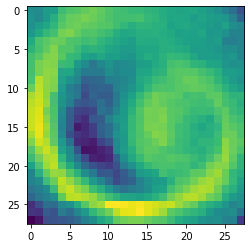

Second Image Original : 


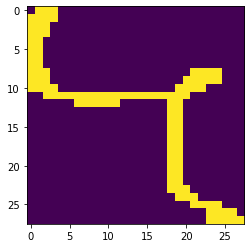

Second Image Reconstructed : 


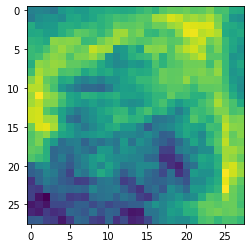

-----------------------------------------------------------------------------------------------
Batch ID:  97
First Image Original : 


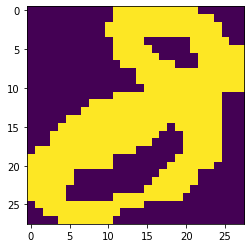

First Image Reconstructed : 


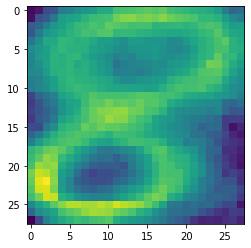

Second Image Original : 


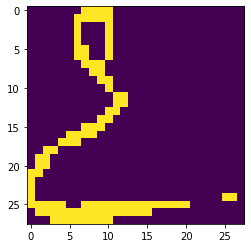

Second Image Reconstructed : 


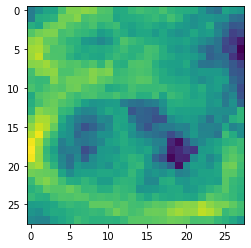

-----------------------------------------------------------------------------------------------
Batch ID:  98
First Image Original : 


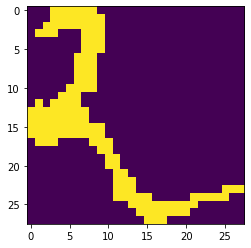

First Image Reconstructed : 


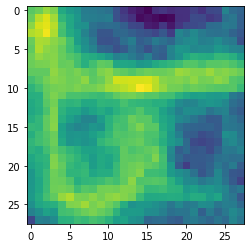

Second Image Original : 


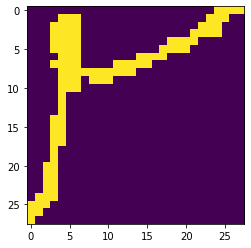

Second Image Reconstructed : 


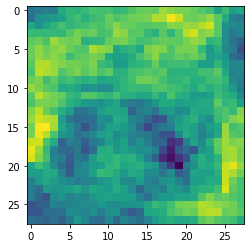

-----------------------------------------------------------------------------------------------
Batch ID:  99
First Image Original : 


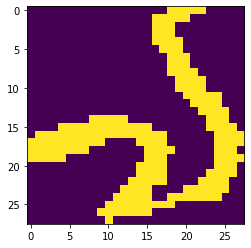

First Image Reconstructed : 


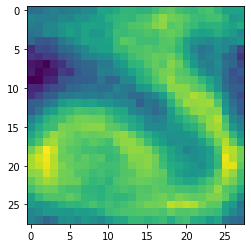

Second Image Original : 


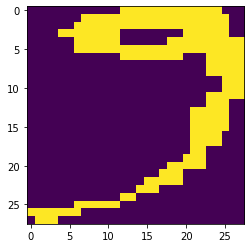

Second Image Reconstructed : 


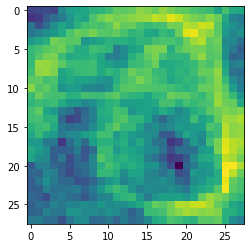

-----------------------------------------------------------------------------------------------
Batch ID:  100
First Image Original : 


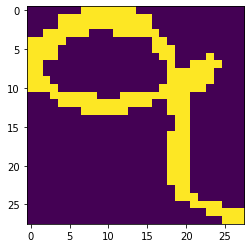

First Image Reconstructed : 


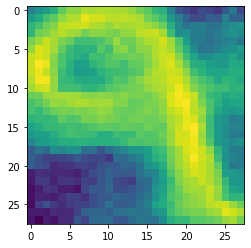

Second Image Original : 


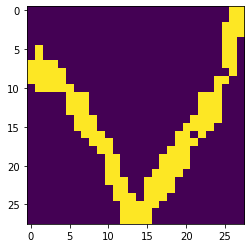

Second Image Reconstructed : 


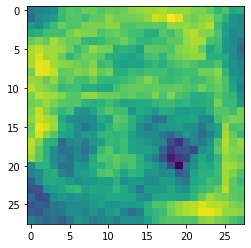

-----------------------------------------------------------------------------------------------
Batch ID:  101
First Image Original : 


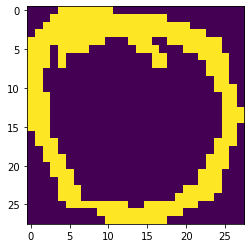

First Image Reconstructed : 


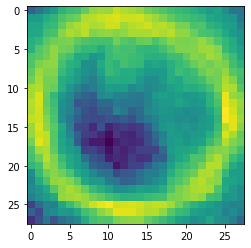

Second Image Original : 


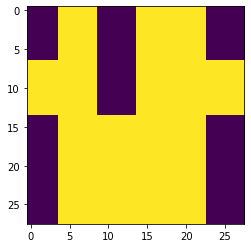

Second Image Reconstructed : 


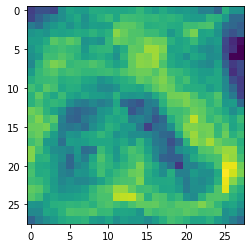

-----------------------------------------------------------------------------------------------
Batch ID:  102
First Image Original : 


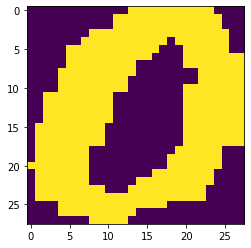

First Image Reconstructed : 


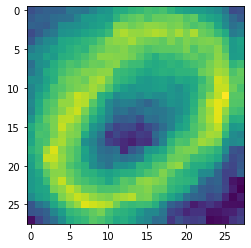

Second Image Original : 


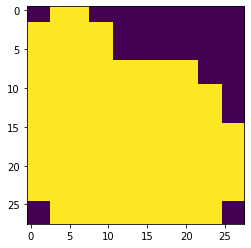

Second Image Reconstructed : 


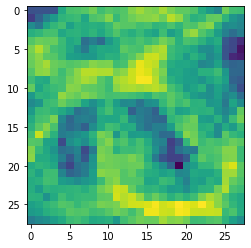

-----------------------------------------------------------------------------------------------
Batch ID:  103
First Image Original : 


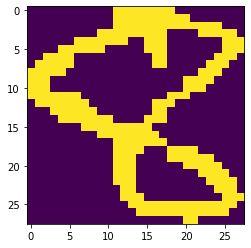

First Image Reconstructed : 


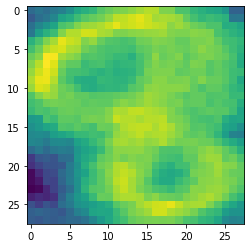

Second Image Original : 


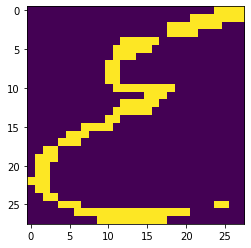

Second Image Reconstructed : 


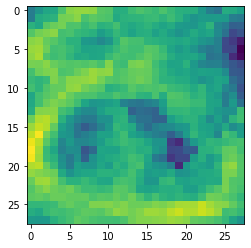

-----------------------------------------------------------------------------------------------
Batch ID:  104
First Image Original : 


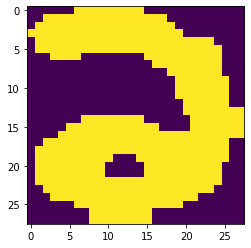

First Image Reconstructed : 


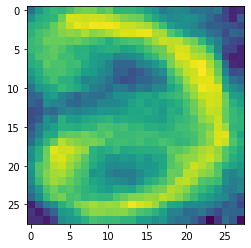

Second Image Original : 


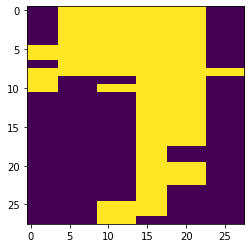

Second Image Reconstructed : 


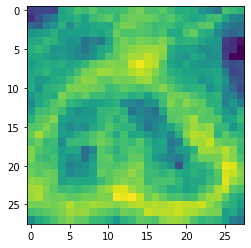

-----------------------------------------------------------------------------------------------
Batch ID:  105
First Image Original : 


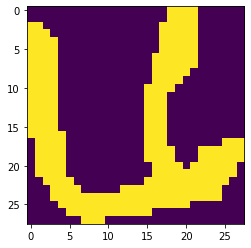

First Image Reconstructed : 


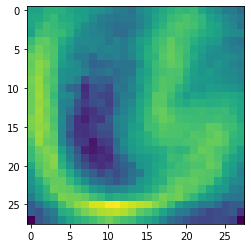

Second Image Original : 


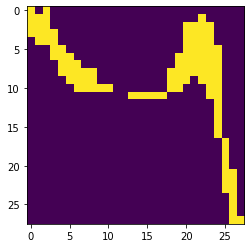

Second Image Reconstructed : 


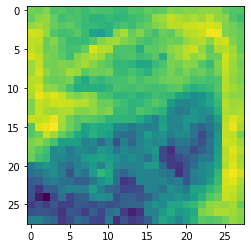

-----------------------------------------------------------------------------------------------
Batch ID:  106
First Image Original : 


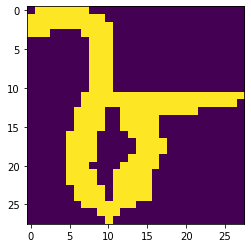

First Image Reconstructed : 


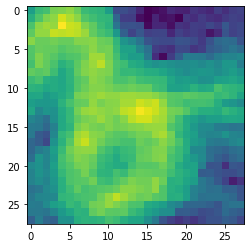

Second Image Original : 


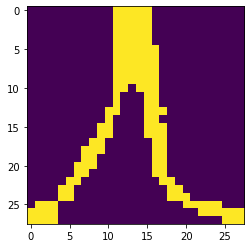

Second Image Reconstructed : 


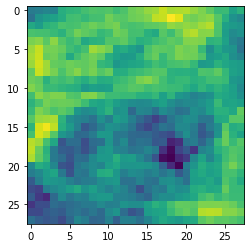

-----------------------------------------------------------------------------------------------
Batch ID:  107
First Image Original : 


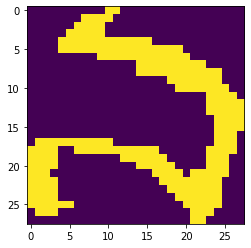

First Image Reconstructed : 


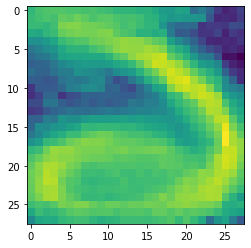

Second Image Original : 


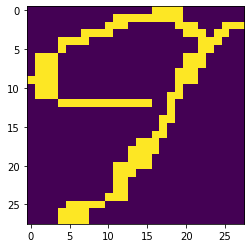

Second Image Reconstructed : 


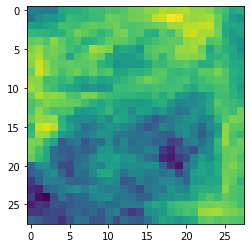

-----------------------------------------------------------------------------------------------
Batch ID:  108
First Image Original : 


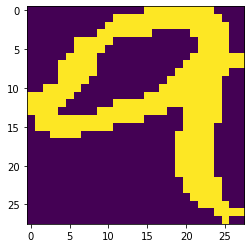

First Image Reconstructed : 


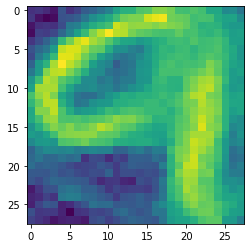

Second Image Original : 


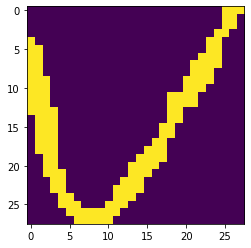

Second Image Reconstructed : 


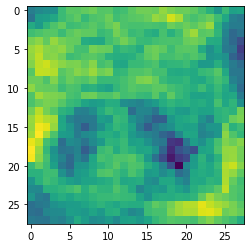

-----------------------------------------------------------------------------------------------
Batch ID:  109
First Image Original : 


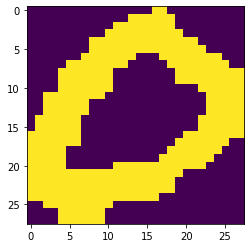

First Image Reconstructed : 


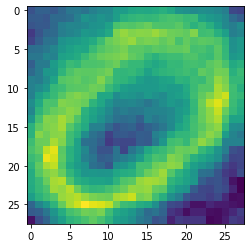

Second Image Original : 


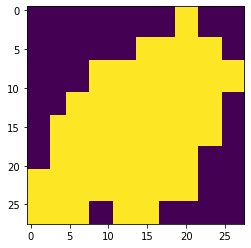

Second Image Reconstructed : 


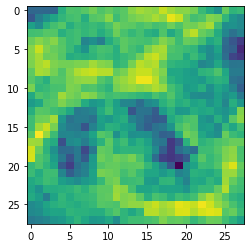

-----------------------------------------------------------------------------------------------
Batch ID:  110
First Image Original : 


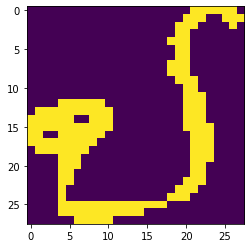

First Image Reconstructed : 


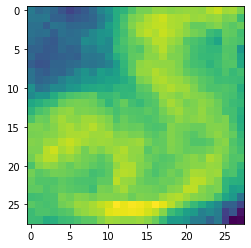

Second Image Original : 


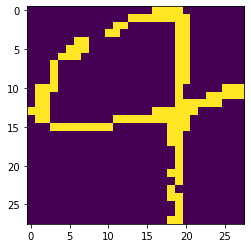

Second Image Reconstructed : 


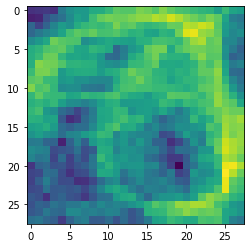

-----------------------------------------------------------------------------------------------
Batch ID:  111
First Image Original : 


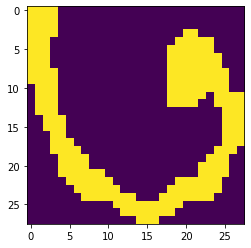

First Image Reconstructed : 


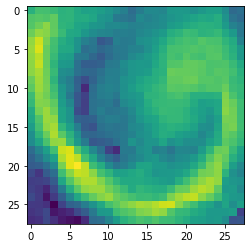

Second Image Original : 


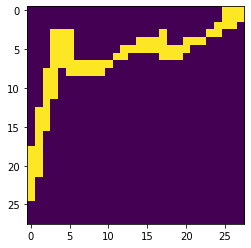

Second Image Reconstructed : 


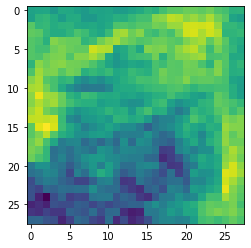

-----------------------------------------------------------------------------------------------
Batch ID:  112
First Image Original : 


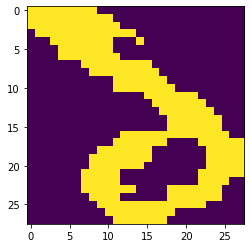

First Image Reconstructed : 


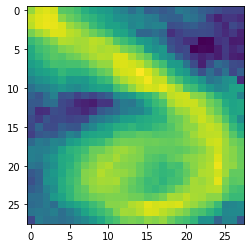

Second Image Original : 


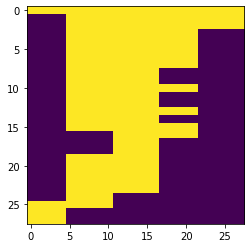

Second Image Reconstructed : 


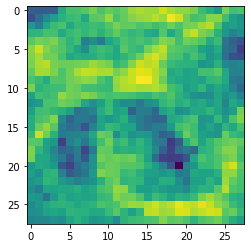

-----------------------------------------------------------------------------------------------
Batch ID:  113
First Image Original : 


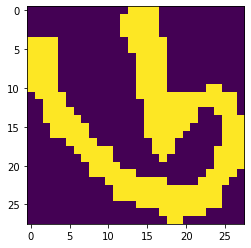

First Image Reconstructed : 


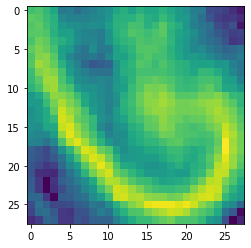

Second Image Original : 


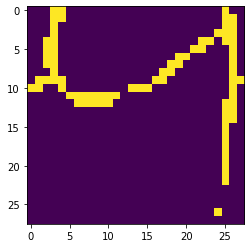

Second Image Reconstructed : 


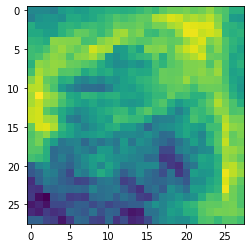

-----------------------------------------------------------------------------------------------
Batch ID:  114
First Image Original : 


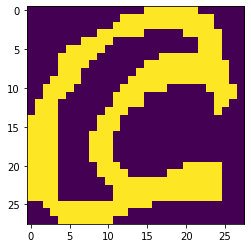

First Image Reconstructed : 


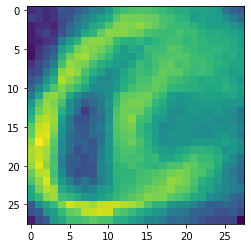

Second Image Original : 


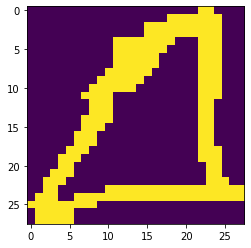

Second Image Reconstructed : 


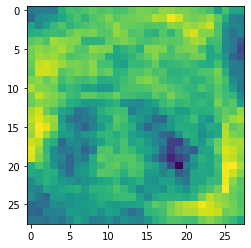

-----------------------------------------------------------------------------------------------
Batch ID:  115
First Image Original : 


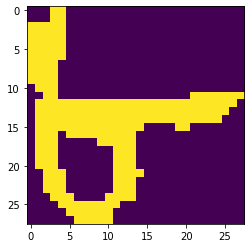

First Image Reconstructed : 


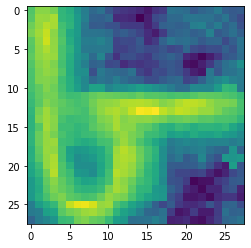

Second Image Original : 


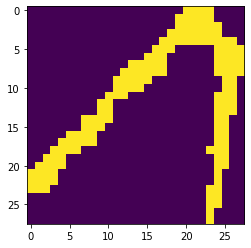

Second Image Reconstructed : 


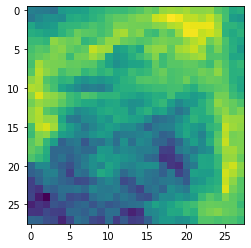

-----------------------------------------------------------------------------------------------
Batch ID:  116
First Image Original : 


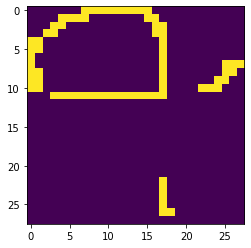

First Image Reconstructed : 


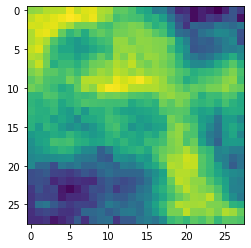

Second Image Original : 


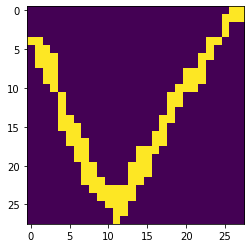

Second Image Reconstructed : 


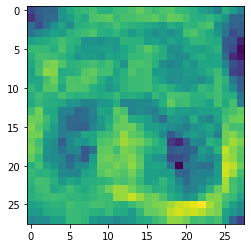

-----------------------------------------------------------------------------------------------
Batch ID:  117
First Image Original : 


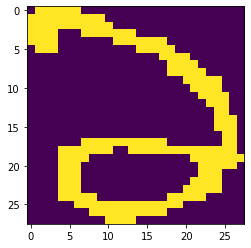

First Image Reconstructed : 


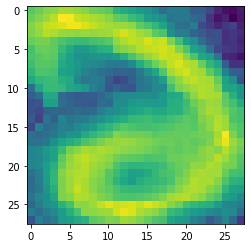

Second Image Original : 


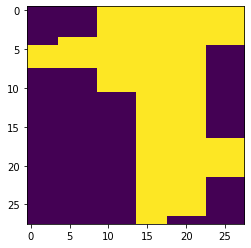

Second Image Reconstructed : 


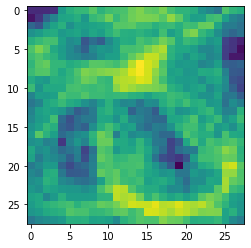

-----------------------------------------------------------------------------------------------
Batch ID:  118
First Image Original : 


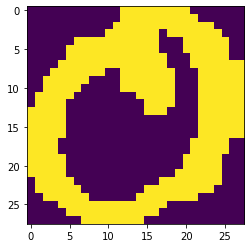

First Image Reconstructed : 


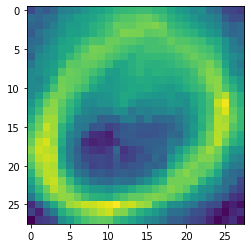

Second Image Original : 


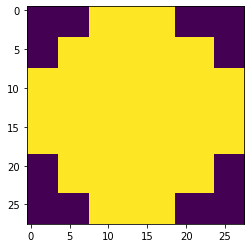

Second Image Reconstructed : 


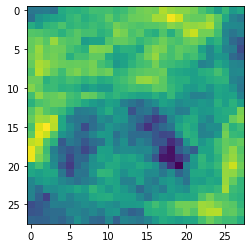

-----------------------------------------------------------------------------------------------
Batch ID:  119
First Image Original : 


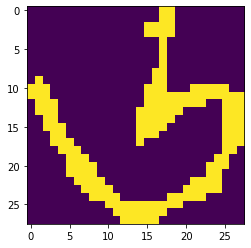

First Image Reconstructed : 


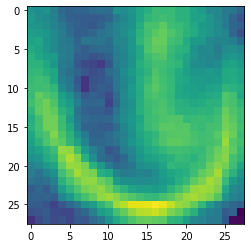

Second Image Original : 


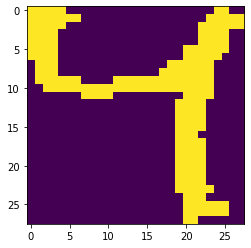

Second Image Reconstructed : 


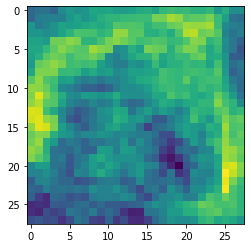

-----------------------------------------------------------------------------------------------
Batch ID:  120
First Image Original : 


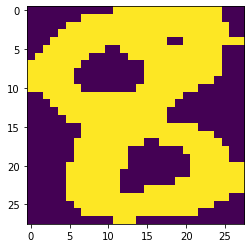

First Image Reconstructed : 


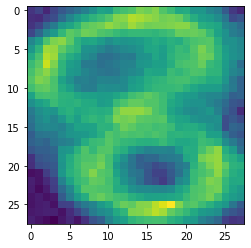

Second Image Original : 


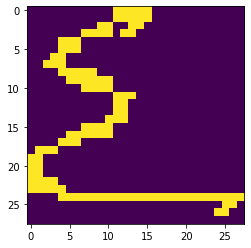

Second Image Reconstructed : 


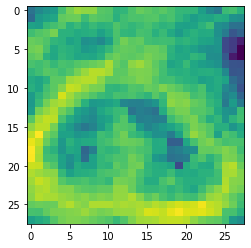

-----------------------------------------------------------------------------------------------
Batch ID:  121
First Image Original : 


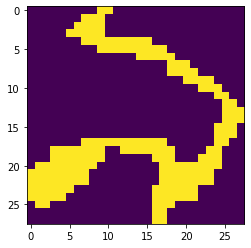

First Image Reconstructed : 


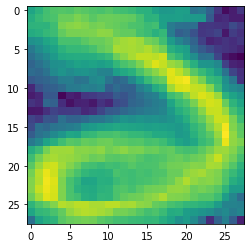

Second Image Original : 


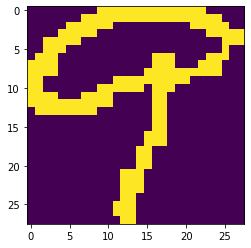

Second Image Reconstructed : 


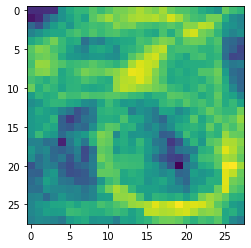

-----------------------------------------------------------------------------------------------
Batch ID:  122
First Image Original : 


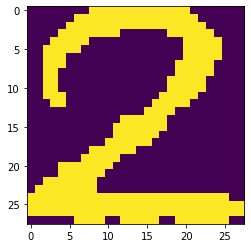

First Image Reconstructed : 


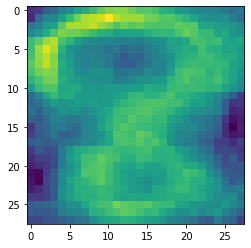

Second Image Original : 


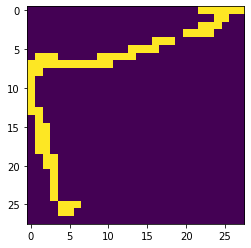

Second Image Reconstructed : 


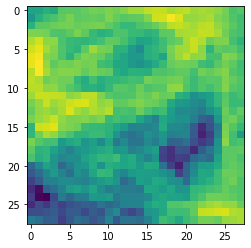

-----------------------------------------------------------------------------------------------
Batch ID:  123
First Image Original : 


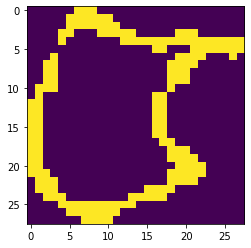

First Image Reconstructed : 


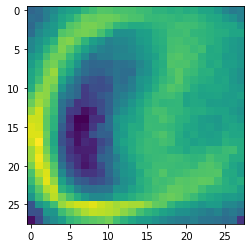

Second Image Original : 


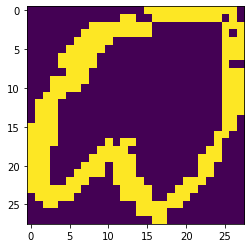

Second Image Reconstructed : 


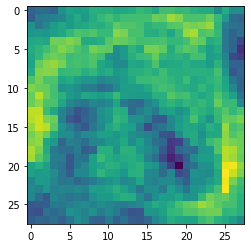

-----------------------------------------------------------------------------------------------
Batch ID:  124
First Image Original : 


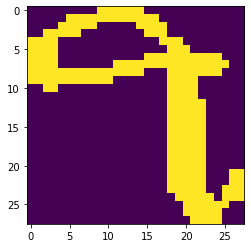

First Image Reconstructed : 


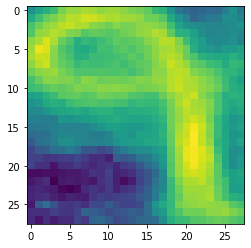

Second Image Original : 


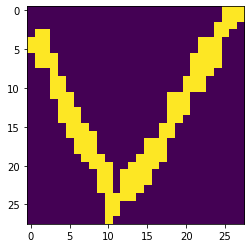

Second Image Reconstructed : 


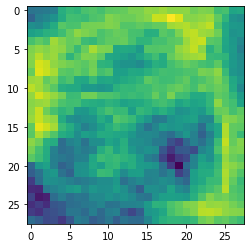

-----------------------------------------------------------------------------------------------
Batch ID:  125
First Image Original : 


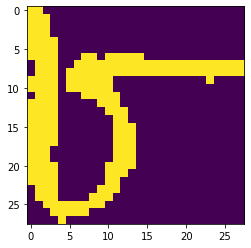

First Image Reconstructed : 


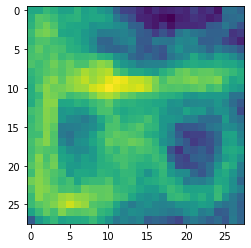

Second Image Original : 


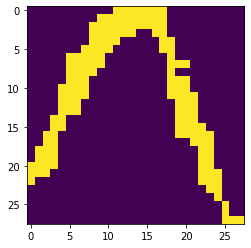

Second Image Reconstructed : 


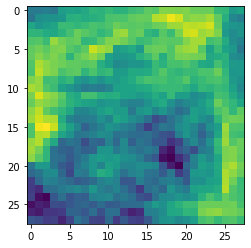

-----------------------------------------------------------------------------------------------
Batch ID:  126
First Image Original : 


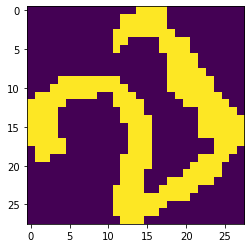

First Image Reconstructed : 


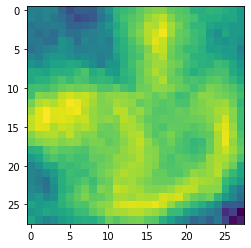

Second Image Original : 


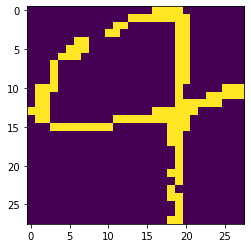

Second Image Reconstructed : 


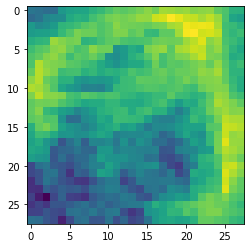

-----------------------------------------------------------------------------------------------
Batch ID:  127
First Image Original : 


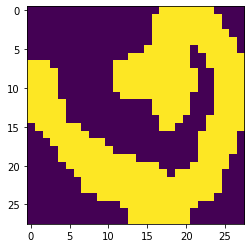

First Image Reconstructed : 


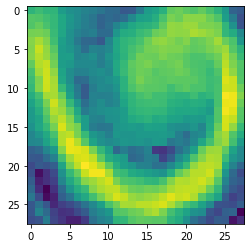

Second Image Original : 


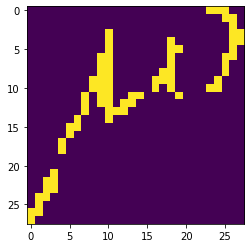

Second Image Reconstructed : 


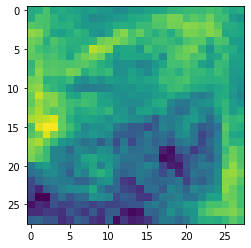

-----------------------------------------------------------------------------------------------
**************************************** Label : 7 ****************************************
**************************************** Label : 1 ****************************************
**************************************** Label : 6 ****************************************
**************************************** Label : 0 ****************************************
**************************************** Label : 8 ****************************************
**************************************** Label : 6 ****************************************
**************************************** Label : 4 ****************************************
**************************************** Label : 5 ****************************************


In [15]:
modalModel.eval()
modelValidationLoss = 0

for _ in range(10):
    
    firstImageOriginal = None
    secondImageOriginal = None
    label = None
    for batchId, ( ( imageFirst, imageSecond, speech ), y ) in enumerate( test_dataset ):
        
        firstImageOriginal = imageFirst
        secondImageOriginal = imageSecond
        #print( 'Corresponding Label: ', y )
        label = np.argmax(y).cpu().detach().numpy()
        # we only take the first instance in the Batch for plot / 
        break
    
    imageFirst = torch.autograd.Variable( imageFirst ).float()
    imageFSecond = torch.autograd.Variable( imageSecond ).float()
    speech = torch.autograd.Variable( speech ).float()
    y = torch.autograd.Variable( y ).float()
    
    # generate reconstructed images
    ( firstImageReconstruct, secondImageReconstruct, speechReconstruct, 
      inferredLabel, mean, logarithmVariance
    ) = modalModel( imageFirst, speech = speech)
    
    # print( firstImageReconstruct.shape ) # => Shape: 128 X 784 i.e. 128 minibatches & (28 X 28) image dimensions
    firstImageReconstruct = firstImageReconstruct.view( 128, 784 )
    secondImageReconstruct = secondImageReconstruct.view( 128, 784 )
    
    # print( firstImageOriginal.shape ) # -> Shape: 128 X 28 X 28 X 1 i.e. 128 minibatches & (28 X 28) image dimensions
    firstImageOriginal = firstImageOriginal.view( 128, 784 )
    secondImageOriginal = secondImageOriginal.view( 128, 784 )
    
    """
    # firstImageReconstruct => Shape: 128 X 784 i.e. 128 minibatches & (28 X 28) image dimensions
    # OriginalFirstImage => Shape: 128 X 28 X 28 X 1 i.e. 128 minibatches & (28 X 28) image dimensions
    
    # Plot the original first Images -> for the first batch 
    print('---------------------------------------------------------------------')
    
    print('First Image Original : ')
    print( firstImageOriginal[0].reshape([28, 28]).shape )
    plt.imshow( firstImageOriginal[0].reshape([28, 28]).cpu().detach().numpy() )
    plt.show()


    # Plot the reconstructed first Images -> for the first minibatch 
    
    print('First Image Reconstructed : ')
    print( firstImageReconstruct[0].reshape([28, 28]).shape )
    plt.imshow( firstImageReconstruct[0].reshape([28, 28]).cpu().detach().numpy() )
    plt.show()
    
    
    print('Second Image Original : ')
    print( secondImageOriginal[0].reshape([28, 28]).shape )
    plt.imshow( secondImageOriginal[0].reshape([28, 28]).cpu().detach().numpy() )
    plt.show()


    # Plot the reconstructed first Images -> for the first minibatch 
    
    print('Second Image Reconstructed : ')
    print( secondImageReconstruct[0].reshape([28, 28]).shape )
    plt.imshow( secondImageReconstruct[0].reshape([28, 28]).cpu().detach().numpy() )
    plt.show()
    
    print('---------------------------------------------------------------------')
    
    """
    
    firstImage = firstImageReconstruct.cpu().detach().numpy()
    secondImage = secondImageReconstruct.cpu().detach().numpy()
    
    firstImageOriginal = firstImageOriginal.cpu().detach().numpy()
    secondImageOriginal = secondImageOriginal.cpu().detach().numpy()
    
    # create directory structure for storing model
    if not os.path.isdir( saveDir + "/m1m2m3/" ):
        os.makedirs( saveDir + "/m1m2m3/" )

    """
        plt.figure( figsize = (60,60) )
        plt.imshow( firstImage )
        figure.set_size_inches(20, 20)
        plt.savefig( saveDir +"/m1m2m3/firstImageReconstructed_" + str(label) + ".png")
        plt.show()


        plt.imshow( firstImageOriginal )
        figure = plt.gcf()
        figure.set_size_inches(18.5, 10.5)
        plt.savefig( saveDir +"/m1m2m3/firstImageOriginal_" + str(label) + ".png" )
        plt.show()

        plt.imshow( secondImage )
        figure = plt.gcf()
        figure.set_size_inches(18.5, 10.5)
        plt.savefig( saveDir +"/m1m2m3/secondImageReconstructed_" + str(label) + ".png" )
        plt.show()

        plt.imshow( secondImageOriginal )
        figure = plt.gcf()
        figure.set_size_inches(18.5, 10.5)
        plt.savefig( saveDir +"/m1m2m3/secondImageOriginal_" + str(label) + ".png" )
        plt.show()

    """
    #print('**************************************** Label : {} ****************************************'.format(label))
    for batchID in range(128):
        
        # For all mini batches obtain the original & reconstructed images for all possible labels (0-9) & store them
        imageStorePath = os.path.join( saveDir, 'm1m2m3', 'Label_{}_Batch_{}'.format(label, batchID) )
        
        if not os.path.isdir( imageStorePath ):
            os.makedirs( imageStorePath )
    
    
            # Plot the original first Images -> for a batch 
            print('Batch ID: ', batchID)
            print('===============================================================================================')

            print('First Image Original : ')
            #print( firstImageOriginal[batchID].reshape([28, 28]).shape )
            plt.imshow( firstImageOriginal[batchID].reshape([28, 28]) )
            plt.savefig( imageStorePath + '/{}_firstImageOriginal_label_{}'.format(batchID, label) + '.png' )
            plt.show()


            # Plot the reconstructed first Images -> for a batch 

            print('First Image Reconstructed : ')
            #print( firstImageReconstruct[batchID].reshape([28, 28]).shape )
            plt.imshow( firstImageReconstruct[batchID].reshape([28, 28]).detach().numpy() )
            plt.savefig( imageStorePath + '/{}_firstImageReconstructed_label_{}'.format(batchID, label) + '.png' )
            plt.show()


            print('Second Image Original : ')
            #print( secondImageOriginal[batchID].reshape([28, 28]).shape )
            plt.imshow( secondImageOriginal[batchID].reshape([28, 28]) )
            plt.savefig( imageStorePath + '/{}_secondImageOriginal_label_{}'.format(batchID, label) + '.png' )
            plt.show()


            # Plot the reconstructed first Images -> for a batch 

            print('Second Image Reconstructed : ')
            #print( secondImageReconstruct[batchID].reshape([28, 28]).shape )
            plt.imshow( secondImageReconstruct[batchID].reshape([28, 28]).detach().numpy() )
            plt.savefig( imageStorePath + '/{}_secondImageReconstructed_label_{}'.format(batchID, label) + '.png' )
            plt.show()

            print('-----------------------------------------------------------------------------------------------')    
